### Link to results
[Proportion of peaks with hits](#peaks-with-hits)

[Examples of motif hits](#example-hits)

[Homotypic density of motifs in peaks](#density)

[Co-occurrence of motifs in peaks](#co-occurrence)

[Distance between co-occurring motifs](#distance)

In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
import os
import util
import moods
import h5py
import viz_sequence
import numpy as np
import pandas as pd
import pomegranate
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import subprocess
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define constants and paths

In [23]:
# Define parameters/fetch arguments

tfm_results_path = os.environ["TFM_TFM_PATH"]
shap_scores_path = os.environ["TFM_SHAP_PATH"]
peak_bed_paths = [os.environ["TFM_PEAKS_PATH"]]
moods_dir = os.environ["TFM_MOODS_DIR"]
reference_fasta = os.environ["TFM_REFERENCE_PATH"]
tomtom_path = os.environ["TFM_TOMTOM_PATH"]
method_input = os.environ["METHOD_INPUT"]

print("TF-MoDISco results path: %s" % tfm_results_path)
print("TF-MoDISco tomtom results path: %s" % tomtom_path)
print("DeepSHAP scores path: %s" % shap_scores_path)
print("Peaks path: %s" % peak_bed_paths[0])
print("MOODS directory: %s" % moods_dir)
print("Reference genome path: %s" % reference_fasta)

TF-MoDISco results path: /oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/DNASE/K562/modisco_crop_500_100K_seqs_1/modisco_results_allChroms_counts.hdf5
TF-MoDISco tomtom results path: /oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/DNASE/K562/modisco_crop_500_100K_seqs_1/counts.tomtom.tsv
DeepSHAP scores path: /mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/nautilus_runs_may18/K562_05.13.2022_bias_128_4_1234_0.5_fold_0/interpret/merged.K562.counts.bw
Peaks path: equal.spaced.merged.k562.new.bed
MOODS directory: /mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/K562_02.08.2022_bias_128_4_2356/06_22_2022_motif_scanning/moods_baseairmodels_counts_new/
Reference genome path: /mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa


In [4]:
# Constants
input_length = 1000 # this is dummy and not used - needs cleanup
hyp_score_key = "hyp_scores" # this is dummy and not used - needs cleanup
motif_fdr_cutoff = 0.10 # change your fdr cut-off threshold here

### Helper functions
For plotting and organizing things

In [5]:
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                try:
                    pattern_name = pattern_name.decode()
                except:
                    pattern_name = pattern_name
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall negative
                if only_pos and np.sum(cwm) > 0:
                    continue
                    
                if trim:
                    pfm = util.trim_motif_new(cwm, pfm)
                    
                pfms["%d_%d" % (metacluster_i,pattern_i)] = pfm
    return pfms

In [6]:
def estimate_mode(x_values, bins=200, levels=1):
    """
    Estimates the mode of the distribution using `levels`
    iterations of histograms.
    """
    hist, edges = np.histogram(x_values, bins=bins)
    bin_mode = np.argmax(hist)
    left_edge, right_edge = edges[bin_mode], edges[bin_mode + 1]
    if levels <= 1:
        return (left_edge + right_edge) / 2
    else:
        return estimate_mode(
            x_values[(x_values >= left_edge) & (x_values < right_edge)],
            bins=bins,
            levels=(levels - 1)
        )

In [7]:
def fit_tight_exponential_dist(x_values, mode=0, percentiles=np.arange(0.05, 1, 0.05)):
    """
    Given an array of x-values and a set of percentiles of the distribution,
    computes the set of lambda values for an exponential distribution if the
    distribution were fit to each percentile of the x-values. Returns an array
    of lambda values parallel to `percentiles`. The exponential distribution
    is assumed to have the given mean/mode, and all data less than this mode
    is tossed out when doing this computation.
    """
    assert np.min(percentiles) >= 0 and np.max(percentiles) <= 1
    x_values = x_values[x_values >= mode]
    per_x_vals = np.percentile(x_values, percentiles * 100)
    return -np.log(1 - percentiles) / (per_x_vals - mode)

In [8]:
def exponential_pdf(x_values, lamb):
    return lamb * np.exp(-lamb * x_values)
def exponential_cdf(x_values, lamb):
    return 1 - np.exp(-lamb * x_values)

In [9]:
def filter_peak_hits_by_fdr(hit_table, fdr_cutoff=0.05):
    """
    Filters the table of peak hits (as imported by `moods.import_moods_hits`)
    by the importance score fraction by fitting a mixture model to the score
    distribution, taking the exponential component, and then fitting a
    percentile-tightened exponential distribution to this component.
    p-values are computed using this null, and then the FDR-cutoff is applied
    using Benjamini-Hochberg.
    Returns a reduced hit table of the same format. This will also generate
    plots for the score distribution and the FDR cutoffs.
    """
    scores = hit_table["imp_frac_score"].values
    scores_finite = scores[np.isfinite(scores)]
    
    mode = estimate_mode(scores_finite)

    # Fit mixture of models to scores (mode-shifted)
    over_mode_scores = scores_finite[scores_finite >= mode] - mode
    mixed_model = pomegranate.GeneralMixtureModel.from_samples(
        [
            pomegranate.ExponentialDistribution,
            pomegranate.NormalDistribution,
            pomegranate.NormalDistribution
        ],
        3, over_mode_scores[:, None]
    )
    mixed_model = mixed_model.fit(over_mode_scores)
    mixed_model_exp_dist = mixed_model.distributions[0]
    
    # Obtain a distribution of scores that belong to the exponential distribution
    exp_scores = over_mode_scores[mixed_model.predict(over_mode_scores[:, None]) == 0]
    
    # Fit a tight exponential distribution based on percentiles
    lamb = np.max(fit_tight_exponential_dist(exp_scores))
    
    # Plot score distribution and fit
    
    fig, ax = plt.subplots(nrows=3, figsize=(20, 20))

    x = np.linspace(np.min(scores_finite), np.max(scores_finite), 200)[1:]  # Skip first bucket (it's usually very large
    mix_dist_pdf = mixed_model.probability(x)
    mixed_model_exp_dist_pdf = mixed_model_exp_dist.probability(x)

    perc_dist_pdf = exponential_pdf(x, lamb)
    perc_dist_cdf = exponential_cdf(x, lamb)

    # Plot mixed model
    ax[0].hist(over_mode_scores + mode, bins=500, density=True, alpha=0.3)
    ax[0].axvline(mode)
    ax[0].plot(x + mode, mix_dist_pdf, label="Mixed model")
    ax[0].plot(x + mode, mixed_model_exp_dist_pdf, label="Exponential component")
    ax[0].legend()

    # Plot fitted PDF
    ax[1].hist(exp_scores, bins=500, density=True, alpha=0.3)
    ax[1].plot(x + mode, perc_dist_pdf, label="Percentile-fitted")

    # Plot fitted CDF
    ax[2].hist(exp_scores, bins=500, density=True, alpha=1, cumulative=True, histtype="step")
    ax[2].plot(x + mode, perc_dist_cdf, label="Percentile-fitted")

    ax[0].set_title("Motif hit scores")
    plt.show()
    
    # Compute p-values
    score_range = np.linspace(np.min(scores_finite), np.max(scores_finite), 1000000)
    inverse_cdf = 1 - exponential_cdf(score_range, lamb)
    assignments = np.digitize(scores - mode, score_range, right=True)
    assignments[~np.isfinite(scores)] = 0  # If score was NaN, give it a p-value of ~1
    pvals = inverse_cdf[assignments]
    pvals_sorted = np.sort(pvals)

    # Plot FDR cut-offs of various levels
    fdr_levels = [0.05, 0.1, 0.2, 0.3]
    pval_threshes = []
    fig, ax = plt.subplots(figsize=(20, 8))
    ranks = np.arange(1, len(pvals_sorted) + 1)
    ax.plot(ranks, pvals_sorted, color="black", label="p-values")
    for fdr in fdr_levels:
        bh_crit_vals = ranks / len(ranks) * fdr
        ax.plot(ranks, bh_crit_vals, label=("Crit values (FDR = %.2f)" % fdr))
        inds = np.where(pvals_sorted <= bh_crit_vals)[0]
        if not len(inds):
            pval_threshes.append(-1)
        else:
            pval_threshes.append(pvals_sorted[np.max(inds)])
    ax.set_title("Step-up p-values and FDR corrective critical values")
    plt.legend()
    plt.show()
    
    # Show table of number of hits at each FDR level
    header = vdomh.thead(
        vdomh.tr(
            vdomh.th("FDR level", style={"text-align": "center"}),
            vdomh.th("Number of hits kept", style={"text-align": "center"}),
            vdomh.th("% hits kept", style={"text-align": "center"})
        )
    )
    rows = []
    for i, fdr in enumerate(fdr_levels):
        num_kept = np.sum(pvals <= pval_threshes[i])
        frac_kept = num_kept / len(pvals)
        rows.append(vdomh.tr(
            vdomh.td("%.2f" % fdr), vdomh.td("%d" % num_kept), vdomh.td("%.2f%%" % (frac_kept * 100))
        ))
    body = vdomh.tbody(*rows)
    display(vdomh.table(header, body))

    # Perform filtering
    bh_crit_vals = fdr_cutoff * ranks / len(ranks)
    inds = np.where(pvals_sorted <= bh_crit_vals)[0]
    if not len(inds):
        pval_thresh = -1
    else:
        pval_thresh = pvals_sorted[np.max(inds)]
    return hit_table.iloc[pvals <= pval_thresh]

In [10]:
def get_peak_hits(peak_table, hit_table):
    """
    For each peak, extracts the set of motif hits that fall in that peak.
    Returns a list mapping peak index to a subtable of `hit_table`. The index
    of the list is the index of the peak table.
    """
    peak_hits = [pd.DataFrame(columns=list(hit_table),  dtype=object)] * len(peak_table)
    for peak_index, matches in tqdm.notebook.tqdm(hit_table.groupby("peak_index")):
        # Check that all of the matches are indeed overlapping the peak
        peak_row = peak_table.iloc[peak_index]
        chrom, start, end = peak_row["chrom"], peak_row["peak_start"], peak_row["peak_end"]
        assert np.all(matches["chrom"] == chrom)
        assert np.all((matches["start"] < end) & (start < matches["end"]))
        
        peak_hits[peak_index] = matches
    return peak_hits

In [11]:
def get_peak_motif_counts(peak_hits, motif_keys):
    """
    From the peak hits (as returned by `get_peak_hits`), computes a count
    array of size N x M, where N is the number of peaks and M is the number of
    motifs. Each entry represents the number of times a motif appears in a peak.
    `motif_keys` is a list of motif keys as they appear in `peak_hits`; the
    order of the motifs M matches this list.
    """
    motif_inds = {motif_keys[i] : i for i in range(len(motif_keys))}
    counts = np.zeros((len(peak_hits), len(motif_keys)), dtype=int)
    for i in tqdm.notebook.trange(len(peak_hits)):
        hits = peak_hits[i]
        for key, num in zip(*np.unique(hits["key"], return_counts=True)):
            counts[i][motif_inds[key]] = num
    return counts

In [12]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

In [13]:
def plot_peak_motif_indicator_heatmap(peak_hit_counts, motif_keys):
    """
    Plots a simple indicator heatmap of the motifs in each peak.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    # Cluster matrix by peaks
    inds = cluster_matrix_indices(peak_hit_indicators, max(5, len(peak_hit_indicators) // 10))
    matrix = peak_hit_indicators[inds]
    
    # Cluster matrix by motifs
    matrix_t = np.transpose(matrix)
    inds = cluster_matrix_indices(matrix_t, max(5, len(matrix_t) // 4))
    matrix = np.transpose(matrix_t[inds])
    motif_keys = np.array(motif_keys)[inds]

    # Create a figure with the right dimensions
    fig_height = min(len(peak_hit_indicators) * 0.004, 8)
    fig, ax = plt.subplots(figsize=(16, fig_height))

    # Plot the heatmap
    ax.imshow(matrix, interpolation="nearest", aspect="auto", cmap="Greens")

    # Set axes on heatmap
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(len(motif_keys)))
    ax.set_xticklabels(motif_keys)
    ax.set_xlabel("Motif")

    fig.tight_layout()
    plt.show()

In [14]:
def plot_homotypic_densities(peak_hit_counts, motif_keys):
    """
    Plots a CDF of number of motif hits per peak, for each motif.
    """
    for i in range(len(motif_keys)):
        counts = peak_hit_counts[:, i]
        
        fig, ax = plt.subplots(figsize=(8, 8))
        bins = np.concatenate([np.arange(np.max(counts)), [np.inf]])
        ax.hist(counts, bins=bins, density=True, histtype="step", cumulative=True)
        ax.set_title("Cumulative distribution of number of %s hits per peak" % motif_keys[i])
        ax.set_xlabel("Number of motifs k in peak")
        ax.set_ylabel("Proportion of peaks with at least k motifs")
        plt.show()

In [15]:
def get_motif_cooccurrence_count_matrix(peak_hit_counts):
    """
    From an N x M (peaks by motifs) array of hit counts, returns
    an M x M array of counts (i.e. how many times two motifs occur
    together in the same peak). For the diagonal entries, we require
    that motif occur at least twice in a peak to be counted.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_motifs = peak_hit_indicators.shape[1]
    count_matrix = np.zeros((num_motifs, num_motifs), dtype=int)
    for i in range(num_motifs):
        for j in range(i):
            pair_col = np.sum(peak_hit_indicators[:, [i, j]], axis=1)
            count = np.sum(pair_col == 2)
            count_matrix[i, j] = count
            count_matrix[j, i] = count
        count_matrix[i, i] = np.sum(peak_hit_counts[:, i] >= 2)
    return count_matrix

In [16]:
def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="greater"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

In [17]:
def plot_motif_cooccurrence_heatmaps(count_matrix, pval_matrix, motif_keys):
    """
    Plots a heatmap showing the number of peaks that have both types of
    each motif, as well as a heatmap showing the p-value of co-occurrence.
    """
    assert count_matrix.shape == pval_matrix.shape
    num_motifs = pval_matrix.shape[0]
    assert len(motif_keys) == num_motifs

    # Cluster by p-value
    inds = cluster_matrix_indices(pval_matrix, max(5, num_motifs // 4))
    pval_matrix = pval_matrix[inds][:, inds]
    count_matrix = count_matrix[inds][:, inds]
    motif_keys = np.array(motif_keys)[inds]
    
    # Plot the p-value matrix

    fig_width = max(5, num_motifs)
    fig, ax = plt.subplots(figsize=(fig_width, fig_width))
    
    # Replace 0s with minimum value (we'll label them properly later)
    zero_mask = pval_matrix == 0
    min_val = np.min(pval_matrix[~zero_mask])
    pval_matrix[zero_mask] = min_val
    logpval_matrix = -np.log10(pval_matrix)
    
    hmap = ax.imshow(logpval_matrix)

    ax.set_xticks(np.arange(num_motifs))
    ax.set_yticks(np.arange(num_motifs))
    ax.set_xticklabels(motif_keys, rotation=90)
    ax.set_yticklabels(motif_keys)

    # Loop over data dimensions and create text annotations.
    for i in range(num_motifs):
        for j in range(num_motifs):
            if zero_mask[i, j]:
                text = "Inf"
            else:
                text = "%.2f" % np.abs(logpval_matrix[i, j])
            ax.text(j, i, text, ha="center", va="center")
    fig.colorbar(hmap, orientation="horizontal")

    ax.set_title("-log(p) significance of peaks with both motifs")
    fig.tight_layout()
    plt.show()
    
    # Plot the counts matrix

    fig_width = max(5, num_motifs)
    fig, ax = plt.subplots(figsize=(fig_width, fig_width))
    
    hmap = ax.imshow(count_matrix)

    ax.set_xticks(np.arange(num_motifs))
    ax.set_yticks(np.arange(num_motifs))
    ax.set_xticklabels(motif_keys, rotation=90)
    ax.set_yticklabels(motif_keys)

    # Loop over data dimensions and create text annotations.
    for i in range(num_motifs):
        for j in range(num_motifs):
            ax.text(j, i, count_matrix[i, j], ha="center", va="center")
    fig.colorbar(hmap, orientation="horizontal")

    ax.set_title("Number of peaks with both motifs")
    fig.tight_layout()
    plt.show()

In [18]:
def create_violin_plot(ax, dist_list, colors):
    """
    Creates a violin plot on the given instantiated axes.
    `dist_list` is a list of vectors. `colors` is a parallel
    list of colors for each violin.
    """
    num_perfs = len(dist_list)

    q1, med, q3 = np.stack([
        np.nanpercentile(data, [25, 50, 70], axis=0) for data in dist_list
    ], axis=1)
    iqr = q3 - q1
    lower_outlier = q1 - (1.5 * iqr)
    upper_outlier = q3 + (1.5 * iqr)


    sorted_clipped_data = [  # Remove outliers based on outlier rule
        np.sort(vec[(vec >= lower_outlier[i]) & (vec <= upper_outlier[i])])
        for i, vec in enumerate(dist_list)
    ]

    plot_parts = ax.violinplot(
        sorted_clipped_data, showmeans=False, showmedians=False, showextrema=False
    )
    violin_parts = plot_parts["bodies"]
    for i in range(num_perfs):
        violin_parts[i].set_facecolor(colors[i])
        violin_parts[i].set_edgecolor(colors[i])
        violin_parts[i].set_alpha(0.7)

    inds = np.arange(1, num_perfs + 1)
    ax.vlines(inds, q1, q3, color="black", linewidth=5, zorder=1)
    ax.scatter(inds, med, marker="o", color="white", s=30, zorder=2)

In [19]:
def plot_intermotif_distance_violins(peak_hits, motif_keys, pair_inds):
    """
    For each pair of motifs, plots a violin of distances beween
    motifs. 
    """
    # First, compute the distribution of distances for each pair
    distances = []
    for i, j in tqdm.notebook.tqdm(pair_inds):
        dists = []
        for k in range(len(peak_hits)):
            hits = peak_hits[k]

            hits_1 = hits[hits["key"] == motif_keys[i]]
            hits_2 = hits[hits["key"] == motif_keys[j]]

            if hits_1.empty or hits_2.empty:
                continue

            pos_1 = np.array(hits_1["start"])
            pos_2 = np.array(hits_2["start"])

            len_1 = (hits_1["end"] - hits_1["start"]).values[0]
            len_2 = (hits_2["end"] - hits_2["start"]).values[0]

            # Differences beteween all pairs of positions
            diffs = pos_2[None] - pos_1[:, None]
            # Take minimum distance for each instance of motif 2, but only
            # if the distance is an appropriate length
            for row in diffs:
                row = row[row != 0]
                if not row.size:
                    continue
                dist = row[np.argmin(np.abs(row))]
                if (dist < 0 and dist < -len_2) or (dist > 0 and dist > len_1):
                    dists.append(dist)
        dists = np.array(dists)
        if not dists.size:
            continue
        distances.append(np.abs(dists))  # Take absolute value of distance
    
    if not distances:
        print("No significantly co-occurring motifs")
        return
    
    # Plot the violins
    fig, ax = plt.subplots(figsize=(int(1.7 * len(pair_inds)), 8))
    create_violin_plot(ax, distances, ["mediumorchid"] * len(pair_inds))
    ax.set_title("Distance distributions between motif instances")
    ax.set_xticks(np.arange(1, len(pair_inds) + 1))
    ax.set_xticklabels(["%s/%s" % (motif_keys[i], motif_keys[j]) for i, j in pair_inds], rotation=90)
    plt.show()

### Import hit results

In [20]:
# Import the PFMs
print(tfm_results_path) 
pfms = import_tfmodisco_motifs(tfm_results_path)
motif_keys = list(pfms.keys())

/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/DNASE/K562/modisco_crop_500_100K_seqs_1/modisco_results_allChroms_counts.hdf5


In [21]:
motif_keys 

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '0_5',
 '0_6',
 '0_7',
 '0_8',
 '0_9',
 '0_10',
 '0_11',
 '0_12',
 '0_13',
 '0_14',
 '0_15',
 '0_16',
 '0_17',
 '0_18',
 '0_19',
 '0_20',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_26',
 '0_27',
 '0_28',
 '0_29',
 '0_30',
 '0_31']

In [24]:
# Import peaks
import util
peak_table = util.import_peak_table_custom(peak_bed_paths)

print(peak_table.head())


  chrom  peak_start  peak_end
0  chr1       40058     41058
1  chr1       41058     42058
2  chr1       42058     43058
3  chr1       45707     46707
4  chr1       46707     47707


In [23]:
# Import DeepSHAP scores

act_scores = util.import_shap_scores_from_bigwig(shap_scores_path,peak_table,input_length)

/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/HEPG2/HEPG2_06.08.2022_bias_128_4_1234_0.8_fold_0/interpret/merged.HEPG2.counts.bw


/mnt/lab_data3/anusri/basepairmodels/basepairmodels/reports/util.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(scores)


In [25]:
import moods
import util

# Run MOODS; import results if they already exist
hits_path = os.path.join(moods_dir, "moods_filtered_scored.bed")
print(hits_path)
print(peak_bed_paths)
print(method_input)

if os.path.exists(hits_path) and os.stat(hits_path).st_size:
    hit_table = moods.import_moods_hits(hits_path)
else:
    collapsed_files_path = os.path.join(moods_dir, "moods_filtered.bed")
    if os.path.exists(collapsed_files_path) and os.stat(collapsed_files_path).st_size:
        hit_table = moods.get_moods_hits_from_collapsed(
            pfms, reference_fasta, peak_bed_paths[0], shap_scores_path, peak_table,
            expand_peak_length=input_length, temp_dir=moods_dir, method=method_input
        )
    else:
        hit_table = moods.get_moods_hits(
            pfms, reference_fasta, peak_bed_paths[0], shap_scores_path, peak_table,
            expand_peak_length=input_length, temp_dir=moods_dir, method=method_input, moods_pval_thresh=0.001
        )

['equal.spaced.merged.k562.new.bed']
/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/K562_02.08.2022_bias_128_4_2356/06_22_2022_motif_scanning/moods_baseairmodels_counts_new/moods_filtered_scored.bed


In [26]:
print(hit_table.head())
print(hit_table.shape)

#hit_table["imp_frac_score"].isnull().values.any()
#hit_table["imp_frac_score"] = lhit_table["imp_frac_score"].fillna(0)

  chrom  start    end   key strand     score  peak_index  imp_frac_score
0  chr1  40204  40222  0_26      +  2.432848           0        0.000769
1  chr1  40295  40313  0_26      +  1.478842           0        0.000643
2  chr1  40929  40947  0_26      -  2.347750           0        0.001471
3  chr1  40070  40082  0_22      +  5.500171           0        0.000331
4  chr1  40914  40926  0_22      +  5.121873           0        0.002419
(32292104, 8)


In [27]:
tomtom = pd.read_csv(tomtom_path, sep="\t")
label_dict = {}
for index,row in tomtom.iterrows():
    keyd = str(row['Pattern']).replace("metacluster_","").replace("pattern_","").replace(".","_")
    label_dict[keyd] = keyd + "_" + str(row['Match_1'])


hit_table['key'] = hit_table['key'].apply(lambda x: label_dict[x] if x in label_dict else x)
hit_table.to_csv(os.path.join(moods_dir, "moods_filtered_scored_tomtom_annotated.bed"), sep="\t", header=False, index=False)

In [28]:
print(hit_table.shape)

temp_keys = []
for keyd in motif_keys:
    if keyd in label_dict:
        temp_keys.append(label_dict[keyd])
    else:
        temp_keys.append(keyd)

motif_keys = temp_keys

(32292104, 8)


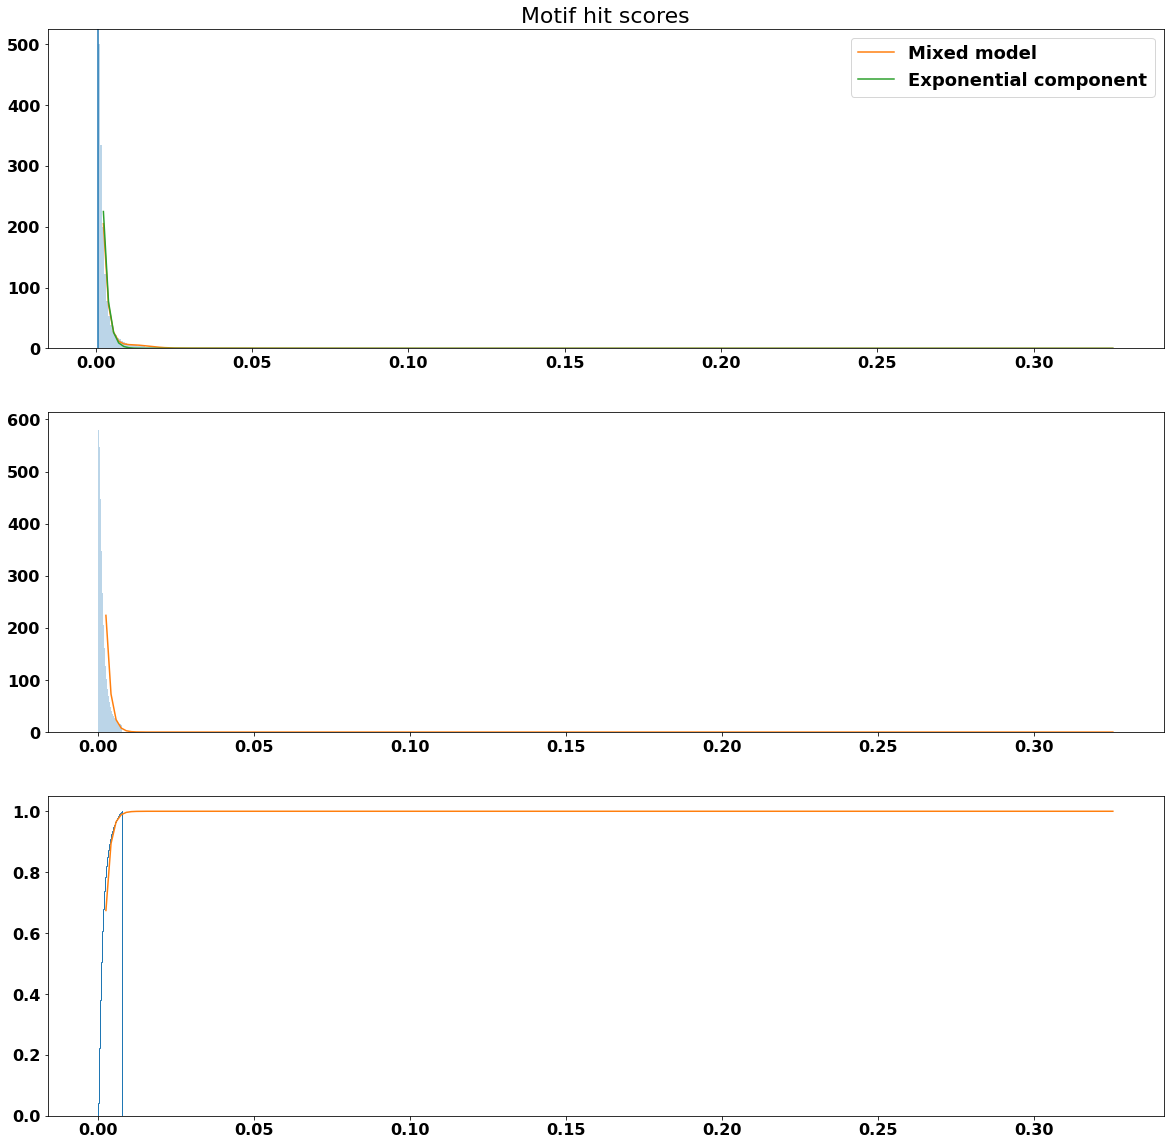

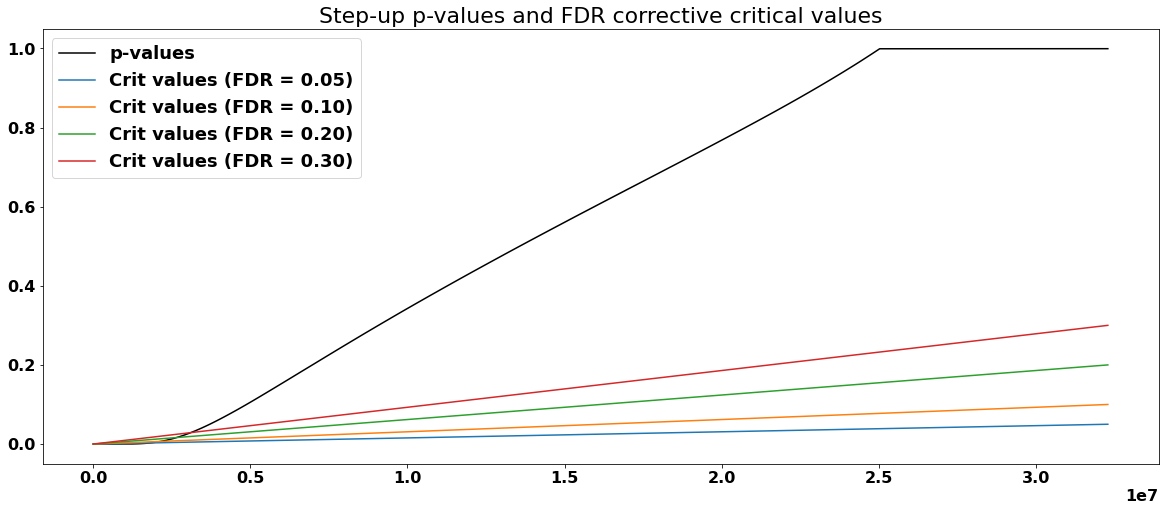

<table><thead><tr><th style="text-align: center">FDR level</th><th style="text-align: center">Number of hits kept</th><th style="text-align: center">% hits kept</th></tr></thead><tbody><tr><td>0.05</td><td>1805700</td><td>5.59%</td></tr><tr><td>0.10</td><td>2146692</td><td>6.65%</td></tr><tr><td>0.20</td><td>2655268</td><td>8.22%</td></tr><tr><td>0.30</td><td>3102145</td><td>9.61%</td></tr></tbody></table>

In [29]:
# Filter motif hit table by p-value using FDR estimation
hit_table_filtered = filter_peak_hits_by_fdr(hit_table, fdr_cutoff=motif_fdr_cutoff)
# Save the results back to MOODS directory
filtered_hits_path = os.path.join(moods_dir, "moods_filtered_scored_thresholded.bed")
hit_table_filtered.to_csv(filtered_hits_path, sep="\t", header=False, index=False)

In [37]:
# Match peaks to motif hits
peak_hits = get_peak_hits(peak_table, hit_table_filtered)

  0%|          | 0/208685 [00:00<?, ?it/s]

In [38]:
# Construct count array of peaks and hits

peak_hit_counts = get_peak_motif_counts(peak_hits, motif_keys)

  0%|          | 0/238076 [00:00<?, ?it/s]

In [39]:
peak_hit_counts.shape

(238076, 32)

In [40]:
# Construct count matrix of motif co-occurrence
motif_cooccurrence_count_matrix = get_motif_cooccurrence_count_matrix(peak_hit_counts)

In [41]:
# Construct the matrix of p-values for motif co-occurrence
motif_cooccurrence_pval_matrix = compute_cooccurrence_pvals(peak_hit_counts)

<a id="peaks-with-hits"></a>
### Proportion of peaks with hits

In [42]:
motifs_per_peak = np.array([len(hits) for hits in peak_hits])

In [43]:
peak_inds = np.where(motifs_per_peak == 0)[0]
print(peak_inds[0:100])

[  3   6  20  23  24  26  27  35  41  42  47  53  58  68  79  84  93 106
 107 112 113 118 122 124 129 130 133 141 142 155 156 157 163 164 169 176
 178 182 185 188 191 192 201 208 213 214 217 219 225 227 236 244 250 251
 258 264 268 286 287 299 301 305 306 308 311 312 316 335 369 373 375 381
 385 392 402 404 408 409 410 411 417 425 427 430 431 435 442 443 452 456
 460 467 468 495 497 498 499 500 501 504]


In [44]:
#hit_table_filtered[hit_table_filtered["peak_index"]==359]

chrom    start      end                        key strand      score  \
28329  chr1  2175206  2175219         0_1_HNF4G_MA0484.1      +  10.347777   
28342  chr1  2174737  2174749  0_6_KLF12_HUMAN.H11MO.0.C      +  10.198894   
28361  chr1  2175175  2175183         0_9_Gabpa_MA0062.2      -   8.889525   

       peak_index  imp_frac_score  
28329         359        0.005028  
28342         359        0.007183  
28361         359        0.004529

In [45]:
display(vdomh.p("Number of peaks: %d" % len(peak_table)))
display(vdomh.p("Number of motif hits before FDR filtering: %d" % len(hit_table)))
display(vdomh.p("Number of motif hits after FDR filtering: %d" % len(hit_table_filtered)))

<p>Number of peaks: 238076</p>

<p>Number of motif hits before FDR filtering: 17331641</p>

<p>Number of motif hits after FDR filtering: 1015047</p>

In [46]:
display(vdomh.p("Number of peaks with 0 motif hits: %d" % np.sum(motifs_per_peak == 0)))

<p>Number of peaks with 0 motif hits: 29391</p>

In [47]:
quants = [0, 0.25, 0.50, 0.75, 0.99, 1]
header = vdomh.thead(
    vdomh.tr(
        vdomh.th("Quantile", style={"text-align": "center"}),
        vdomh.th("Number of hits/peak", style={"text-align": "center"})
    )
)
body = vdomh.tbody(*([
    vdomh.tr(
        vdomh.td("%.1f%%" % (q * 100)), vdomh.td("%d" % v)
    ) for q, v in zip(quants, np.quantile(motifs_per_peak, quants))
]))
vdomh.table(header, body)

<table><thead><tr><th style="text-align: center">Quantile</th><th style="text-align: center">Number of hits/peak</th></tr></thead><tbody><tr><td>0.0%</td><td>0</td></tr><tr><td>25.0%</td><td>2</td></tr><tr><td>50.0%</td><td>4</td></tr><tr><td>75.0%</td><td>6</td></tr><tr><td>99.0%</td><td>14</td></tr><tr><td>100.0%</td><td>28</td></tr></tbody></table>

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


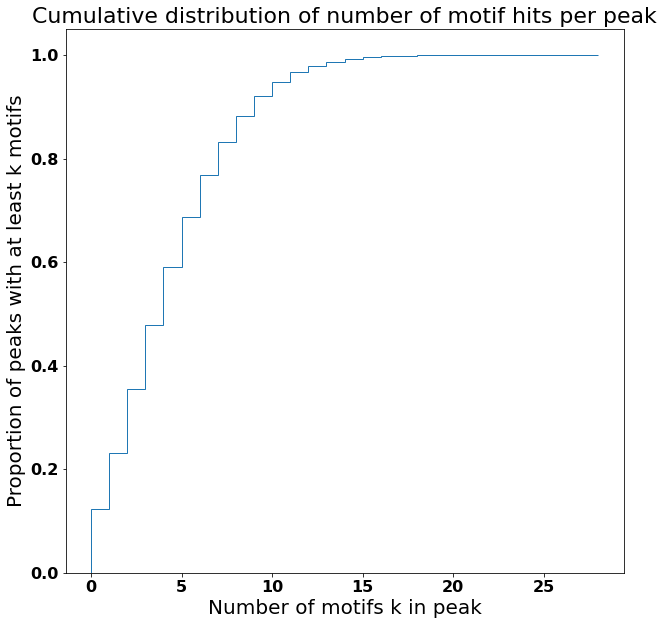

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
bins = np.concatenate([np.arange(np.max(motifs_per_peak) + 1), [np.inf]])
ax.hist(motifs_per_peak, bins=bins, density=True, histtype="step", cumulative=True)
ax.set_title("Cumulative distribution of number of motif hits per peak")
ax.set_xlabel("Number of motifs k in peak")
ax.set_ylabel("Proportion of peaks with at least k motifs")
plt.show()

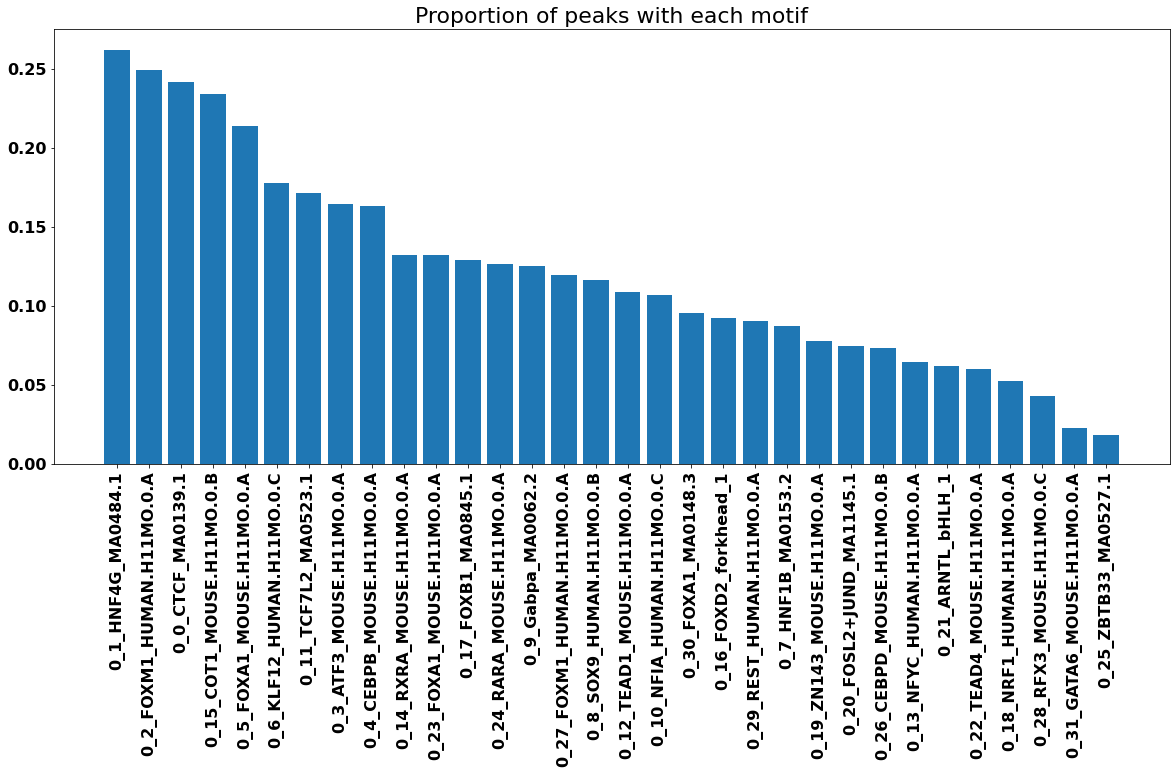

In [49]:
frac_peaks_with_motif = np.sum(peak_hit_counts > 0, axis=0) / len(peak_hit_counts)
labels = np.array(motif_keys)
sorted_inds = np.flip(np.argsort(frac_peaks_with_motif))
frac_peaks_with_motif = frac_peaks_with_motif[sorted_inds]
labels = labels[sorted_inds]

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(np.arange(len(labels)), frac_peaks_with_motif)
ax.set_title("Proportion of peaks with each motif")
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.show()

<a id="example-hits"></a>
### Examples of motif hits in sequences

In [62]:
# Show some examples of sequences with motif hits

import pyfaidx
import one_hot

num_to_draw = 3
unique_counts = np.sort(np.unique(motifs_per_peak))
motif_nums = []
if 0 in motifs_per_peak:
    motif_nums.append(0)
if 1 in motifs_per_peak:
    motif_nums.append(1)
motif_nums.extend([
    unique_counts[0],  # Minimum
    unique_counts[len(unique_counts) // 2],  # Median
    unique_counts[-1],  # Maximum
])

for motif_num in np.sort(np.unique(motif_nums)):
    display(vdomh.h4("Sequences with %d motif hits" % motif_num))
    
    peak_inds = np.where(motifs_per_peak == motif_num)[0]
    table_rows = []
    for i in np.random.choice(
        peak_inds, size=min(num_to_draw, len(peak_inds)), replace=False
    ):
        print(i)
        peak_coord = peak_table.iloc[i][["chrom", "peak_start", "peak_end"]].values
        motif_hits = peak_hits[i]
        
        chrom, peak_start, peak_end = peak_coord
        print(chrom, peak_start, peak_end)
        peak_len = peak_end - peak_start
        #mask = (shap_coords[:, 0] == chrom) & (shap_coords[:, 1] <= peak_start) & (shap_coords[:, 2] >= peak_end)
        #if not np.sum(mask):
        #    fig = "No matching input sequence found"
        #    table_rows.append(
        #        vdomh.tr(
        #            vdomh.td("%s:%d-%d" % (chrom, peak_start, peak_end)),
        #            vdomh.td(fig)
        #        )
        #    )
        #    continue
            
        #seq_index = np.where(mask)[0][0]  # Pick one
        seq_index = i
        imp_scores = act_scores[seq_index]
        _, seq_start, seq_end = chrom, peak_start, peak_end
        
        highlights = []
        for _, row in motif_hits.iterrows():
            start = row["start"] - peak_start
            end = start + (row["end"] - row["start"])
            highlights.append((start, end))
        
        # Remove highlights that overrun the sequence
        highlights = [(a, b) for a, b in highlights if a >= 0 and b < peak_len]
        
        start = peak_start - seq_start 
        end = start + peak_len
        imp_scores_peak = imp_scores[start:end]
        
        genome="/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"
        hg38 = pyfaidx.Fasta(genome)    
        seq = str(hg38[chrom][peak_start:peak_end])
        
        one_hot_seq = one_hot.dna_to_one_hot(seq).squeeze()
    
        imp_scores_peak_n =   np.array(one_hot_seq).T * np.array(imp_scores_peak)
        print(imp_scores_peak_n.shape)
        imp_scores_peak_n =imp_scores_peak_n.T
        fig = viz_sequence.plot_weights(
            imp_scores_peak_n, subticks_frequency=(len(imp_scores_peak_n) + 1),
            highlight={"red" : [pair for pair in highlights]},
            return_fig=True
        )
        fig = util.figure_to_vdom_image(fig)
        
        table_rows.append(
            vdomh.tr(
                vdomh.td("%s:%d-%d" % (chrom, peak_start, peak_end)),
                vdomh.td(fig)
            )
        )

    table = vdomh.table(*table_rows)
    display(table)
    plt.close("all")

<h4>Sequences with 0 motif hits</h4>

109344
chr2 2806628 2807628
(4, 1000)
7249
chr1 53517164 53518164
(4, 1000)
95816
chr17 81249346 81250346
(4, 1000)


<table><tr><td>chr2:2806628-2807628</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAB8ZUlEQVR4nO3ddZxU1fvA8c%2Bdme1edtkldukukRSQEhAFv9hgYNfPbrFgsRsLVETAAGxJpQUElJDuroUN2O6J8/vjTu7OFuyygM/79VqYuTVn7tx8zrnP0ZRSCCGEEEIIIYQQQgghhBBVzVDTBRBCCCGEEEIIIYQQQghxYZIAtBBCCCGEEEIIIYQQQohqIQFoIYQQQgghhBBCCCGEENVCAtBCCCGEEEIIIYQQQgghqoUEoIUQQgghhBBCCCGEEEJUCwlACyGEEEIIIYQQQgghhKgWEoAWQgghhBBCCCGEEEIIUS0kAC2EEEIIIYQQQgghhBCiWkgAWgghhBBCCCGEEEIIIUS1kAC0EEIIIYQQQgghhBBCiGohAWghhBBCCCGEEEIIIYQQ1UIC0EIIIYQQQgghhBBCCCGqhQSghRBCCCGEEEIIIYQQQlQLCUALIYQQQgghhBBCCCGEqBYSgBZCCCGEEEIIIYQQQghRLSQALYQQQgghhBBCCCGEEKJamGq6AEJUpaioKNWwYcOaLoYQQgghhBBCCCHEBePff/89qZSKrulyiPOTBKDFBaVhw4asX7%2B%2BposhhBBCCCGEEEIIccHQNO1wTZdBnL8kBYcQQgghhBBCCCGEEEKIaiEBaCGEEEIIIYQQQgghhBDVQgLQQgghhBBCCCGEEEIIIaqFBKCFEEIIIYQQQgghhBBCVAsJQAshhBBCCCGEEEIIIYSoFhKAFkIIIYQQQgghhBBCCFEtJAAthBBCCCGEEEIIIYQQolpIAFoIIYQQ4lyRvBwOfF3TpRBCCCGEEEKIKiMBaCGEEEKIc8Xa%2B6DO5TVdCiGEEEIIIYSoMhKAFkIIIYQ4ZygIiK3pQgghhBBCCCFElZEAtBBCCCHEuULZaroEQgghhBBCCFGlJAAthBBCCHGuUNYKTTZ2LHTsWM1lEUIIIYQQQogqIAFoIYQQQohzhc1coclmzoRNm6q1JEIIIYQQQghRJSQALYQQQghxrrAWVGgypaq5HEIIIYQQQghRRSQALYQQQghxrghtXqHJLJZqLocQQgghhBBCVBEJQIsyaZoWqWnah5qmHdY0rVDTtOOapk3WNC2ugvMbNU17QtO0rZqm5Wualq5p2h%2BapvXwMu2DmqbN1TQtVdM0Zf9bX/XfSgghhDhHdZtcockKC6u5HEIIIYQQQghRRUw1XQBx7tI0LQxYBbR0G1wHuBMYrGnaJUqpw%2BUs5lvgJrf3/sBgYICmacOUUr%2B7jbsP6HDmJRdCCCHOVwqKMqHoFAQ3LnWqvLyzWCQhhBBCCCGEOAPSAlqUZTSu4PM7QC3gUfv7OsD7Zc2sadpVuILPS%2B3z9AFy0Ss/Jmma5us2y0zgEeDaKii7EEIIcf7RNNj4DMxuUuZkISHQtOlZKpMQQgghhBBCnAEJQAuvNE3TgNvtb/OAl5VSaUqpT4AD9uHDNE2LKGMxd7i9HqOUSlJKrQB%2BsA%2BrA1zumEAplaCU%2BhTYWBXfQQghhDiv2KyAASy55U763Xewd2/1F0kIIYQQQgghzpQEoEVpGqG3eAbYp5Qqchu33f6/CehYxjK6eJmn%2BGv3aYQQQoj/LlsRaAYwZ9R0SYQQQgghhBCiykgAWpQmxu11ZrFx7u9rn8YyKjq/EEII8d/hCEAXFT/tlmQ0noXyCCGEEEIIIUQVkAC0OB1aDc/vuTBNu0/TtPWapq1PTU2tykULIYQQZ4/NjJ6CI7vMyZQCg1zBCSGEEEIIIc4TcvsiSpPs9jq82LhQt9cpp7GMis5fIUqpiUqpzkqpztHR0We6OCGEEKJmKAsYTBDaAjq%2BW%2BpkVqveV6EQQgghhBBCnA8kAC1KcxA4ZX/dVNM0X7dxbez/Wyi7w8B1bq9be5m/%2BDRCCCHEf5eygeYD9YZBq6dLnaywEEwmGDdOAtFCCCGEEEKIc58EoIVXSikFfG1/GwC8qmlahKZpjwCN7cNnKaXSNU3rq2masv9NdVuM%2B%2BuxmqbFaJrWBxhuH3YCWOCYQNO0ME3TooAIt/lMmqZF2f/8qu4bCiGEEOcapbeAVrYypyoqAl9f2LbtLBVLCCGEEEIIIc6ABKBFWV4BdtlfPwukAR/b3ycBT5U1s1JqDjDD/ra/fZ5lQBB66%2Bl7lVJFbrPMAlKBDW7DOtiHpQI3neb3EEIIIc4DCjQjGMuub7XZwMcHTp48S8USQgghhBBCiDMgAWhRKqVUJtATPeh8BDCjB5GnAl2VUocrsJjbgCeBbUAhkAnMB/oopeZVQ7GFEEKI85NS%2Bv%2Bm4HIn8/WF9PSzUCYhhBBCCCGEOEOmmi6AOLcppdKAx%2Bx/pU2zDPCahVIpZQHG2f/K%2B6y%2Bp1VIIYQQ4oKgAA2M/mVPpcBo1HNBN2hwdkomhBBCCCGEEKdLWkALIYQQQpwT7C2gywlA22x654N33AGHDlV7oYQQQgghhBDijEgAWgghhBDiXKCUHlk2lJ0D2jmZXMUJIYQQQgghzgNy6yKEEOewwkJISqrpUgghzg5HCo6KBaBDQs5OqYQQQgghhBDiTEgAWgghzmHvvw916rj6JnP6uRaYc%2BjXD5KTa6RoQojqopV9eSYBaCGEEEIIIcT5RALQQghxrln3EOz6EIB9%2B/RBmns3n8oGRWngE8yOHRATc9ZLKISoLsreCrq8SYCAgOovjhBCCCGEEEKcKQlACyHEuWbvBGh4MwDHj3sZX5TufGm1nqUyCSHOAg2wldsC2iEgALILszmWeax6iyWEEEIIIYQQZ0AC0EIIcS5xNG30rw1ArVrw%2BefFpik8CVE9AGjT5iyWzRtl8wiICyHOgGbQ96lyWkA7nogICIB2n7Uj7sO46i%2BbEEIIIYQQQpwmCUALIcS5xJwJERc533btCvffDwQHQ2ysfZosGLQKpeCnn2qklADs3g2Lv/oBfo4EJU2xhThzmh6A1soPQCsFRuNZKpYQQgghhBBCnAEJQAshxLnEnAlXbHS%2BDQqyv8jNdfU2mLUHgIICsNnOcvncvPcerJ6/U3%2BjSSTsv%2BjYMejZEzIza7okFwj3wPN0o/5XymRKgcEACoW/BhyYCjapCBJCCCGEEEKceyQALYQQ5xJztsfbyEgv49fcDUBOTrkNJavVsWPQOPYQBNStuUIIjh%2BHuXNr5rMXLoTVq8Hfv2Y%2B/8Kj6dk3lAJs9j8vU9kD0Pr/iqFBwD93ypMIQgghhBBCiHOSBKCFEOJcUiwAHRxcbHzuEfDRB%2Bbl1ewj%2BNHRcMUNTeCaxJorhOCtt%2BCqq2qmNfyxY2A0WPA7OhHMOWe/AOebHe/Ab/XKmECz/5Bl/5iOiidNA5uyEW%2ByjzD6VkUphRBCCCGEEKJKSQBaCCHOJdY8j7fOFBwAMTGQfxzqDtUntYKPD3z6KVx88Vkso90ll0Ct2iFn/4OFh/379f8NNXBGt1jAcnwVrL1f0rBUxIkF%2Bj7sxUUXQU6uBlhcnZGWwmDQ938Ai81C69A6cMWmKi2qEEIIIYQQQlQVCUALIcQ5xTOnhsnk9iYpCYoyoP4wAObu/h2jSfHzz7BxI2ddVBRgCjz7Hyw8tGgBqak189khIUDuIdAMYAqomUJUp4ytkFhOfpNjs%2BHgtxVcoAZ1BpcYajbD5s0QHGwAmwUoOwCtafo8SukB6OZ1OkNEhwqWQQg

<h4>Sequences with 1 motif hits</h4>

91397
chr17 51119816 51120816
(4, 1000)
58704
chr14 24352310 24353310
(4, 1000)
196992
chr6 127100641 127101641
(4, 1000)


<table><tr><td>chr17:51119816-51120816</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAACbrUlEQVR4nOyddZiUVRuH73did7Y7qaW7RURAEOzEVuzG1s/CBOzuwE4UA0UUEQxCpLs7tztnd%2Bo93x9ncnd2aRaWc1/X7M6ct85bJ37nOc%2BjCSFQKBQKhUKhUCgUCoVCoVAoFAqF4mBjaOwMKBQKhUKhUCgUCoVCoVAoFAqFommiBGiFQqFQKBQKhUKhUCgUCoVCoVAcEpQArVAoFAqFQqFQKBQKhUKhUCgUikOCEqAVCoVCoVAoFAqFQqFQKBQKhUJxSFACtEKhUCgUCoVCoVAoFAqFQqFQKA4JSoBWKBQKhUKhUCgUCoVCoVAoFArFIUEJ0AqFQqFQKBQKhUKhUCgUCoVCoTgkKAFaoVAoFAqFQqFQKBQKhUKhUCgUhwQlQCsUCoVCoVAoFAqFQqFQKBQKheKQoARohUKhUCgUCoVCoVAoFAqFQqFQHBKUAK1QKBQKhUKhUCgUCoVCoVAoFIpDghKgFQqFQqFQKBQKhUKhUCgUCoVCcUhQArRCoVAoFAqFQqFQKBQKhUKhUCgOCUqAVigUCoVCoVAoFAqFQqFQKBQKxSFBCdAKhUKhUCgUCoVCoVAoFAqFQqE4JCgBWqFQKBQKhUKhUCgUCoVCoVAoFIcEU2NnQKE4mCQmJoqMjIzGzoZCoVAoFAqFQqFQKBQKRZNh6dKlhUKIpMbOh%2BLoRAnQiiZFRkYGS5YsaexsKBQKhUKhUCgUCoVCoVA0GTRN29nYeVAcvSgXHAqFQqFQKBQKhUKhUCgUCoVCoTgkKAFaoVAoFAqFQqFQKBQKhUKhUCgUhwQlQCsUCoVCoVAoFAqFQqFQKBQKheKQoARohUKhUCgUCoVCoVAoFAqFQqFQHBKUAK1QKBQKhUKhUCgUCoVCoVAoFIpDghKgFQqFQqFQKBQKhUKhUCgUCoVCcUhQArRCoVAoFAqFQqFQKBQKhUKhUCgOCUqAVigUCoVCoVAoFAqFQqFQKBQKxSFBCdAKhUKhUCgUCoVCoVAoFAqFQqE4JCgBWqFQHDts/gAcFY2dC4VCoVAoFAqFQqFQKBSKYwYlQCsUiqZPRgZoGnQYBSHR8nvtT0ZGY%2BdSoVAoFAqFQqFQKBQKhaLJoQRohULR9Nm5E4qXwwRAiOCfnTsbO5cKhUKhUCgUCoVCoVAoFE0OJUArFIpjA2d1Y%2BdAoVAoFAqFQqFQKBQKheKYQwnQigbRNC1e07Q3NE3bqWmaTdO0bE3TPtU0rcVebm/UNO0%2BTdNWa5pWrWlaiaZp0zRNO7HWehmapr2kadp89zFs7mP%2Bomna8Yfm7BTHFHpNY%2BdAoVAoFAqFQqFQKBQKheKYw9TYGVAcuWiaFgP8B3TyS04DrgfO0DRtgBBiT34LvgKu8PttAc4ATtE07XwhxO/u9BOAB2tt29L9OUfTtIuEEJP370wUCpQFtEKhUCgUCoVCoVAoFApFI6AsoBUN8SQ%2B8fklIAG42/07DXi1oY01TTsXn/j8j3ubIUAVcvDjY03TQvw2mQdcDMQCqcC37nQD8NQBnIdCwYP3KwtohUKhUCgURx%2BaBuXljZ0LhUKhUCgUiv1HCdCKoGiapgHXun9agSeEEMVCiLeBbe708zVNi2tgN9f5fR8jhMgVQswBvnOnpQGnu79PFUIMFEJMEkKUCSHy8IndAB0O5HyOFaqrYcuWxs7FkUnWbiVAKxQKhUKhODqJjm7sHCgUCoVCoVDsP0qAVtRHa6TFM8AWIYTdb9la938T0LuBffQLsk3t7/0AhBAVQba3%2BH3f3WBuFQBMnAjt24MQtRYsuQu2f90oeTpSCDMrFxwKhUKhUCiOLuq06RQKhUKhUCiOQpQAraiPFL/vZbWW%2Bf9O3o997O32z/l9H9/Aego3eXnyv6bVWrDpHUg/47Dn50gi1GyDkaoXp1AoFAqF4ujBbt/zOgqFQqFQKBRHOkqAVuwPteXNg7q9JnkbuNqdNBl4vYH1b9E0bYmmaUsKCgoOMGtHN5WVDSwMTTxs%2BTgSiYtXMVcVCoVCoVAcXVSrCVwKhUKhUCiaAEqAVtRHnt/32FrL/L3Q5e/HPurdXtM0M/A1cKc7aTJwmRBCr%2B8gQogPhRDHCSGOS0pKaiA7TR8VoKZ%2BIiIPdNxEoVAoFArFAfFzM3AE87qmqA8lQCsUCoVCoWgKKAFaUR/bgSL393aapoX4Levq/u8Eljewj8V%2B37sE2T5gHU3TwoFfgJHupE%2BAi2v5n1Y0QEWwPp1yHghAWJi6DgqFQqFQNCrV2WCOauxcHFVYrY2dA4VCoVAoFIoDRwnQiqAIIQTwhftnGPC0pmlxmqbdBbRxp/8ihCjRNG2opmnC/fncbzf%2B38dpmpaiadoQ4DJ3Wg4wHUDTtFhgBnCme9lzQoibhBCug31uTZmgArSr5rDn40jEYlEW0AqFQqFQKI4uqqshSmn2CoVCoVAojnKUAK1oiKeADe7vDwHFwFvu37nA/Q1tLIT4FfjW/XOYe5tZQATSevpmP%2BvmEcBAv80f9RO1PZ%2BMAzqbY4CqqiCJLmU6A3DbrcoCWqFQKBSKRkPNyNov7HblYk2hUCgUCsXRjxKgFfUihChDisJvAbsAB1JE/hw4Xgixcy92cw3wP2ANYAPKgD%2BAIUKIqYcg28c0zZrBpk21El3VYFKmM6A6vgqFQqFQNBaDBypnxvuDXTmiUygUCoVC0QQwNXYGFEc2Qohi4B73p751ZgFB/RsIIZzA6%2B5PQ8f5nECXHYr9oHVraN%2B%2BVqLLBpf6mc5s%2BxwW3AjocIUO2jHimkJ5c1EoFAqFolFwOGD9ajUja39wOBo7BwqFQqFQKBQHjrKAViiaEEZjkES9lulM0SJAl9%2BPFfEZUBbQCoVCoVA0DuXlEGEJ5idMsSeUBbRCoVAoFIqmgBKgFYomhNkcJLG2AO04Rh0JKt%2BTCoVCoVA0ClVVYDHXwNlrGzsrRx3KAlqhUCgUCkVTQAnQCkUTIiQkSKJeq%2BdiLzsseTni0FRxp1AoFApFY1BZCSEmO8R0aeysHHU4nY2dA4VCoVAoFIoDRykyCkUTwmKpm3bix/0CE5wVhyczRxyquFMoFAqFojGoqoIQo/IlsT%2B4VAgLhUKhUCgUTQClyCgUTYhgLjhCart5dvgJ0I5y%2BEarayXdFNEM0g3HNxo4rWjjNM6acFZj50qhUCgUiiZPVRV0aKsE6P1BWUArFAqFQqFoCpgaOwMKheLgEcwFh7m2AB3ZFiwp0OdVKF0j0wzBnEc3MTTAViC/m8IByKvMa7z8KBQKhUJxjFBTA99OUAK0QqFQKBQKxbGKsoBWKJoQwSygw2uLy2mnQdKJENP52ApIKKhzvgIVmFChUCgUikONzUbdoMiKetm%2BHTRNud9QKBQKhULRdFACtELRhAhqAW2qJUALl8/i%2BVjzB%2B0IPF%2BN2ubhTYDISEhNbexcKBQKhULhxenk2HD3dZBYsUL%2BNxrBoHprCoVCoVAomgDKBYdC0YQIDa2bZjbUUqUNoaC50xzHkACtUUdwb5IW0FVV8qNQKBQKxRGCywUI5cx4byk/hiaoKRQKhUKhODZQY%2BoKRRPCFGRIyWysJUCbI8HoJ0B3uOPQZ%2BxIQACOSmh/jJyvQqFQKBRHCLre2Dk4ulACtEKhUCgUiqaGEqAViiaEVsujhBACo1

<h4>Sequences with 13 motif hits</h4>

207401
chr7 75397894 75398894
(4, 1000)
150107
chr22 42993683 42994683
(4, 1000)
152006
chr3 13393416 13394416
(4, 1000)


<table><tr><td>chr7:75397894-75398894</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAABeW0lEQVR4nO3ddZhbZdrH8e8Z106nNnUHWgoUKAWKtDhdFhaWhRe3XZYFFltYXFrcF3e34m4F6u7uPtWZjnsmdr9/nMxMRmsznUJ/n%2BvKlRx7zpPkJDm5c%2Bd%2BHDNDRERERERERERERKSxRTR3B0RERERERERERETkj0kBaBERERERERERERFpEgpAi4iIiIiIiIiIiEiTUABaRERERERERERERJqEAtAiIiIiIiIiIiIi0iQUgBYRERERERERERGRJqEAtIiIiIiIiIiIiIg0CQWgRURERERERERERKRJKAAtIiIiIiIiIiIiIk1CAWgRERERERERERERaRIKQIuIiIiIiIiIiIhIk1AAWkRERERERERERESahALQIiIiIiIiIiIiItIkFIAWERERERERERERkSahALSIiIiIiIiIiIiINAkFoEVERERERERERESkSUQ1dwdEGlObNm2se/fuzd0NEREREREREZE/jNmzZ2ebWdvm7of8PikALX8o3bt3Z9asWc3dDRERERERERGRPwzHcdKbuw/y%2B6USHCIiIiIiIiIiIiLSJBSAFhEREREREREREZEmoQC0iIiIiIiIiIiIiDQJBaBFREREREREREREpEkoAC0iIiIiIiIiIiIiTUIBaBERERERERERERFpEgpAi4iIiIiIiIiIiEiTUABaRERERERERERERJqEAtAiIiIiIiIiIiIi0iQUgBYRERERERERERGRJqEAtIg0rfJcKMto7l6IiIiIiIiIiEgziGruDojIHqx7d0hPb%2B5euLp1g3XrmrsXIiIiIiIiIiKyAxSAFpH6paeD2fav7zi119%2BeeXWtU1fbIiIiIiIiIiLyu6ISHCIivyfdu7vB%2BOa%2BdO/e3I%2BEiIiIiIiIiPwOKAAtIvJ7UpGVXt%2BlQvh02PIXnjcc6tlue9qsuN5TSrOIiIiIiIiIyB5NAWgRkb1IXl5z90BERERERERE9iYKQItIk3h6ytOsL1jf3N2QGkpKmrsHIiIiIiIiIrI30SCEItIk/vvbf1mRs4LXmrsjUo0C0CIiIiIiIiKyOykDWkSajGHbXkl2myVLYO7c5u6FiIiIiIiIiOxNFIAWkSbj4DR3FyTMk0/ClCnN3QsRERERERER2ZsoAC0iTUYZ0HsWn6%2B5eyAiIiIiIiIiexsFoEVE9hJlZc3dAxERERERERHZ2ygALSKylygpgSFDwJSYLiIiIiIiIiK7iQLQItJ0FOnco5SWQu/ezd0LEREREREREdmbKAAtIk3Hgs3dAwlTWgqxsc3dCxERERERERHZmygALSJNJtLZMwPQZWXNPyDfsqxlTN84fbfu0%2BOBuLjduksRERERERER2ctFNXcHROSPK2JPyYDu3h3S0ysn4xujzW7dYN26%2BpdHRUEgUO/iPjvS1q7yFYETgc%2BXSHyj3HkRERERERERke2jDGhpkOM4rRzHedZxnHTHccodx9nsOM7bjuN02c7tIx3H%2BY/jOAsdxylzHCfPcZyfHcc5qo51rYHLY41/76SpRbKHBKDT06vqUZvhYO50XZfQOtu8hAW0ATfI7ThVlwaCz3TrRswD0TjDw/rXlD5vAf5i7rwTOnZs2l2JiIiIiIiIiIRTBrTUy3GcFGAy1ZM1OwBXAEMdxxlkZtuKnH0AXBA2HQcMBU5yHOdMM/upMfsse5aIPSUAHSbYVF0KD3KDG4SuOQjjCAcuNHcZ0U3UkXrEpREdrRrQIiIiIiIiIrJ7KQNaGnIfVcHnJ4DWwA2h6Q7A0w1t7DjOGVQFn8eEthkClOD%2B%2BPGm4zgxdWx6hZk5NS537NpdkeYQ2WTR3p1XVtbcPWg%2BEREQvZvj3iIiIiIiIiKyd1MAWurkOI4DXBaaLAXuNbNcM3sBWBOaf6bjOKkNNHN52O1hZpZhZhOAT0PzOgCnNmK3ZY/TQBmKZlJa2tw9cPmD/t2%2BT8dRAFpEREREREREdi8FoKU%2BPXAzngFWmZk3bNni0HUUcEgDbQysY5uat8PXqfCU4zhex3GKHMeZ4jjOZXWsI78HNUtQ7AHCA9CnfXQaw8YO2z07DvqqTRq7/7GJiYHIyN2%2BWxERERERERHZiykALfVJC7tdUGNZ%2BHS7nWhjW9u3xi2QmwQMAt51HOfJBvYjeyizPa8ER3gA%2BudVP/P01AYryTQef/OnXsfHKwNaRERERERERHYvBaBlZzhNtP1juAHnVKAVcBNUpone7DhO1zobc5yrHMeZ5TjOrKysrF3smjQmCxuEcPlyuOaaZuxMiMcD/t1f/QICpRDdshl2DDjuW31MjALQIiIiIiIiIrJ7KQAt9ckMu92yxrIWYbe37kQbdW5vZnea2TQzyzezPDN7DhgdWhwBHF7XTszsdTM7zMwOa9u2bQPdkd3NwkpwfP89vPoqNPe4hF5vM5WhCHjg3Lxm2DHwf272dXS0G4QGICkJ2rdvnv6IiIiIiIiIyF5DAWipz1ogJ3S7t%2BM4MWHL%2BoWu/cDcBtqYGXZ7/zq2r1zHcZz6jkWr57bswSoCz8GwQQizs93riGZ%2B1/F6t71Ok6hRA3q3iowF3AB0VFRoXkkJZGbWv42IiIiIiIiISCNQAFrqZG4E8b3QZDzwoOM4qY7jXA/0DM3/1szyHMc5znEcC13eDWsm/Pb9juOkOY4zBDgvNG8L8Evo9rWO47znOM4Qx3ESHcdp6TjODcBJoeV%2BYFrj3ktpKsFQ7WcLS3fOa6bk35qaLwDdXDuuEh0Nzq4W0BERERERERER2QEKQEtDHgCWhW7fBuQCz4emM4BbGtrYzL4HPg5NnhDaZhyQiBtQ/qeZVUTlooBLQ8uLgTzgOarqRQ8zs027dG9kt6kIQAetKgO6oOZQls2kZgDamjKxPjkR7o0Fb94eEYCOilIAWkRERERERER2LwWgpV5mVgAcjRt0Xg/4cIPI7wKHm1n6djRzKXAzsAgoBwqAkcAQM/sxbL3vgUdxS3JsxQ1Q5%2BBmSJ9uZo80wl2S3SQQCjzviQHoigEInft3QyS2dSn09UJk/B4RgFYGtIiIiIiIiIjsblHbXkX2ZmaWC9wYutS3zjiqMpVrLvMDz4QuDe1nNXBX6CK/cxUZ0IFgVQA6IQFuaTBnfveoCEBXCB8osdFVDLcZGbdHBKCbZfBFEREREREREdmrKQNaRBpdReA5PAP68MPhqaeaq0dVAoHq04aBvwxKtiehfwfFhd1u5gB0U8bZRURERERERETqowC0iDS6igzof9jiynkRe%2Bi7jZnBypfh2%2B6NH6WND7sd9Ne72u5g5pbfUAkOEREREREREdmd9tCQkIj8nlXUgB4UkVM5Lza2uXpTXc1AeNCCULbZnWjs6Gw8EFFxx5s38hsegK6Ms6elNWufREREREREROSPTwFoEanTyJE7v21FBnSl344jIWHX%2BtNYasaYgxYET3bT7Kx1KzjfQ9xDcQRqPibNoFZ8PSOjWfohIiIiIiIiInsPBaBFpE4//7zz24YPPghA1nji4%2Btet7kFLQje3KZpPK0TgWCA8kA5vj2kBMceZ/xZ4Cts7l6IiIiIiIiISBNRAFpE6pS9C0nBQQvWenOJidml7jSammWe3UEISyGpV%2BPvrEUyvqAPgEDAvaZ9%2B8bfz3aoCEDvcYHoTd9CdIvm7oWIiIiIi

<h4>Sequences with 28 motif hits</h4>

33097
chr11 18118625 18119625
(4, 1000)
204172
chr7 26363503 26364503
(4, 1000)


<table><tr><td>chr11:18118625-18119625</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAABTkklEQVR4nO3dd3xUVfrH8c%2BZmfSEFFqooQuKCgKCioIoigVx7RVddXXVta69geVn76669t7b2ruIVKVL74QaCOl9MjPn98edJJOeQEJAvu/Xa8jce88998ydQvLcZ55jrLWIiIiIiIiIiIiIiDQ1V0sPQERERERERERERET%2BmhSAFhEREREREREREZFmoQC0iIiIiIiIiIiIiDQLBaBFREREREREREREpFkoAC0iIiIiIiIiIiIizUIBaBERERERERERERFpFgpAi4iIiIiIiIiIiEizUABaRERERERERERERJqFAtAiIiIiIiIiIiIi0iwUgBYRERERERERERGRZqEAtIiIiIiIiIiIiIg0CwWgRURERERERERERKRZKAAtIiIiIiIiIiIiIs1CAWgRERERERERERERaRYKQIuIiIiIiIiIiIhIs1AAWkRERERERERERESahaelByDSlNq0aWO7devW0sMQEREREREREfnLmDNnznZrbduWHofsmRSAlr%2BUbt26MXv27JYehoiIiIiIiIjIX4YxJrWlxyB7LpXgEBEREREREREREZFmoQC0iIiIiIiIiIiIiDQLBaBFREREREREREREpFkoAC0iIiIiIiIiIiIizUIBaBERERERERERERFpFgpAi4iIiIiIiIiIiEizUABaRERERERERERERJqFAtAiIiIiIiIiIiIi0iwUgBYRERERERERERGRZqEAtIiIiIiIiIiIiIg0CwWgRUT2NN26gTG79tatW0s/ahERERERERHZA3laegAiInutbt0gNbV5j5GSgkldh7W1bDeG8o3GOD9raly2TURERERERESkEZQBLSJ7lx8OhfQZlVZt3QqfftoCY0lNdYK9oTeovq6mNmXtamofuq25A9wiIiIiIiIiInVQBrSI7FmaJGv40EpL7YFTGttFSgqsW7eT4xARERERERER%2BWtTBrSI7FlqyhpuTObwO1TbZ8JdFkMdWcY13ZRZLCIiIiIiIiJSLwWgRWSvl5fX0iMQEREREREREflrUgBaRPZ6%2BflN1FG3bs5kfQ29QcPWhd66dWuiwYqIiIiIiIiIND8FoEVkr1dQ0EQd1VYepLaSHlWWzcSQNjW1V%2BkPEREREREREdnDKAAtInu9JgtAi4iIiIiIiIhIJQpAi8her7CwpUcANjTruYl9%2B22zdS0iIiIiIiIiUicFoEVkr1dU1NIjgIANNFvfY8Y0W9ciIiIiIiIiInVSAFrqZIxJMsY8aYxJNcaUGGM2G2NeNcZ0aeD%2BbmPMdcaYhcaYImNMljHmW2PMoTW0tXXcHmz6Ryd7pXOqZxr37QurV9fc/LPPmnk8QX7r3zUHEhERERERERHZhTwtPQDZfRlj4oFpQN%2BQ1R2AvwNjjDGHWGvrmxHtLeDskOVIYAxwtDFmnLX2m6Ycs8iO6N0bevSoeduIEbtmDP6AAtAiIiIiIiIi8tejDGipy11UBJ8fBloDVweXOwCP1bWzMWYsFcHnX4L7jAAKcC5%2BvGyMCa9h179ba02V2y0791BEdkxS0q45TnOW4BARERERERERaSkKQEuNjDEGuCC4WAjcaa3NtNY%2BA6wJrh9njEmso5sLQ%2B5PsNamWWt/Az4IrusAHNuEwxbZIZ7d4LsgKsEhIiIiIiIiIn9FCkBLbbrjZDwDrLLWekO2LQ7%2B9AAD6%2BhjSA37VL0f2qbMo8YYrzEmzxgz3RhzQQ1tRJpMWFhLj0AlOERERERERETkr2k3yPuT3VT7kPs5VbaFLrfbgT7q278s8B0GHAIcYozpb629sY5jieyw6OiWHoFKcIiIiIiIiIjIX5MyoGVHmGba/0GcgHMikARcC9jgtuuNMV1r7MyYS40xs40xs9PT03dyaLI3ioxs6RGoBIeIiIiIiIiI/DUpAC212RpyP6HKtlYh97ftQB817m%2BtvdVaO9Nam22tzbLWPgX8HNzsAg6u6SDW2hettYOttYPbtm1bx3CkKdxzD0yd2tKjaFotXYLD6/Myc8PMlh2EiIiIiIiIiEgzUABaarMWyAje72WMCQ/Ztl/wpw%2BYV0cfs0Lu71vD/uVtjDG1vRZtLfdlR3TrBsbs1O2uCYbhhzdyv27dWvqR16mlJyH8dtW3jPtgXMsOYgds2waTJrX0KERERERERERkd6YAtNTIWmuBN4KLUcC9xphEY8xVQI/g%2Bs%2BttVnGmJHGGBu8vR7STej9u40x7Y0xI4Azg%2Bu2AN8H719hjHnDGDPCGBNjjEkwxlwNHB3c7gOUIrqzUlPB2vpvUPmnteByYY0LQx3ta%2BsrNXXXP9ZGaOkM6J0uatMSunWjXXvDkaP%2BGhchRERERERERKR5KAAtdbkHWBa8fxOQCTwdXE4D/l3XztbaL4H3goujgvv8CsTgBJT/Ya31Brd7gPHB7flAFvAUFaG5CdbaTTv1aGTnBAIU2YiWHkWzaOkAtLV7YHJ/aiqX/9NWviARBrwDlOZVvxCxm1%2BEEBEREREREZHmoQC01MpamwMchhN0Xg%2BU4gSRXwcOttY2JKI0HrgeWASUADnAd8AIa%2B3XIe2%2BBB7AKcmxDSdAnYGTIX2itfb%2BJnhIspPyia19o8dTc%2BZrmR0p%2BbGLtHQAelcVlwkEAgQCgSbrLzu7yoq44E9PHa8TEREREREREdmrtHDlU9ndWWszgWuCt9ra/EotRQSstT7gieCtruOsBm4L3mQ3VRaA7tULZs2CxMSQjX5/RcmNUGWBZGud%2B%2B8A59TSLnT/XRiADg%2Bvv01zMrvosXru9WCx2AlNE/HOyamyIrJJuhURERERERGRvxBlQItIg%2BUTS/fusHp1leDzHs7Vwp%2BEAdsEWckZs%2BCnI%2BtsYps41Tovr8oKBaBFREREREREpAoFoEWkwYqJZM2alh7FX4sxEAg0QWB483ew7VdoimB2A/n90Lt3yAoFoEVERERERESkCgWgRaTBvLRwrYpmsgurfdQogH/nOynZ5vw0u%2B5j/dxzYcWKkBURQPfxu%2Bz4IiIiIiIiIrL7UwBaRBqshAh8vp3tpYWjvbshf2AnA9CxseDNaprBNIK/6rDDgEPe2OXjEBEREREREZHdlwLQItJgJSaS/Hzo128nOjknWCLC7XZuu4GWzoAuDZTuXAcFBeDNbpKxNEZERJUVcdG7fAwiIiIiIiIisntTAFpEGswfFUtRESxZ0gSdBQLObTfQ0gHonc6ABvAXQ6u%2BO99PI8TFhSzExkKr2F16fBERERERERHZ/SkALSIN5ouIoaSkpUexk2z1Cf9aMgCdkQG%2BQOPrmvS7EqamTq1Y4dsXTlxaY9saHnKTiA5NeC4ogFZxtbYVERERERERkb2TAtAi0mD%2B8CiKi2vffvzxThxyT9RcQdr6JCXtWAB6WVv4cMmHFSuq1cOo0FwB9mqHjI4CoM8zffhj0x/Nc1ARERERERER2aMoAC0idUovSOfjxR8DYCLC6wxAf/steDyNP8aUKTs4uB3148hqq1oyC3pHAtAAhAbNI%2BObZCyNUS0AHeWsWJm5ks%2BXf77LxyMiIiIiIiIiu58dCBWJyN7ktp9v4%2BV5L2MBV0RYvSU46kjErdURR1SOpTYrYyB9cqVVLZX9XGZHJyG0JmTgMUlNNJqGq/Zch4esaO

In [53]:
#peak_table.iloc[301945]

In [ ]:
print(hit_table_filtered)
hit_table_filtered[hit_table_filtered["chrom"]=="chr10"][hit_table_filtered["start"]>6918031][hit_table_filtered["end"]<6919031]
                                                                                              
                                                                                              
                                                                                              
                                                                                              

<a id="density"></a>
### Homotypic motif densities
For each motif, show how many the motif occurs in each peak

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


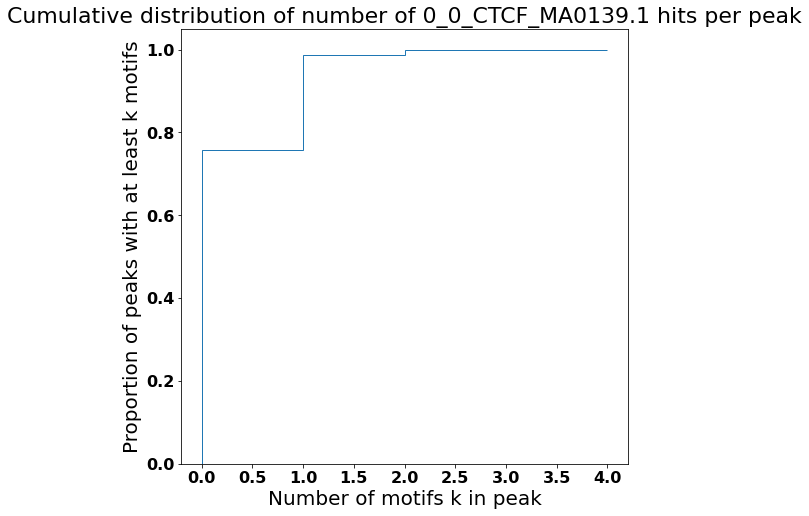

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


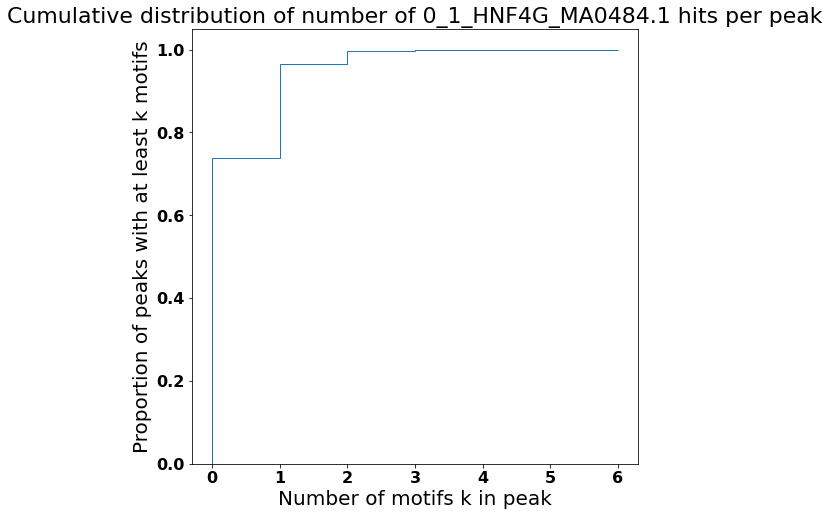

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


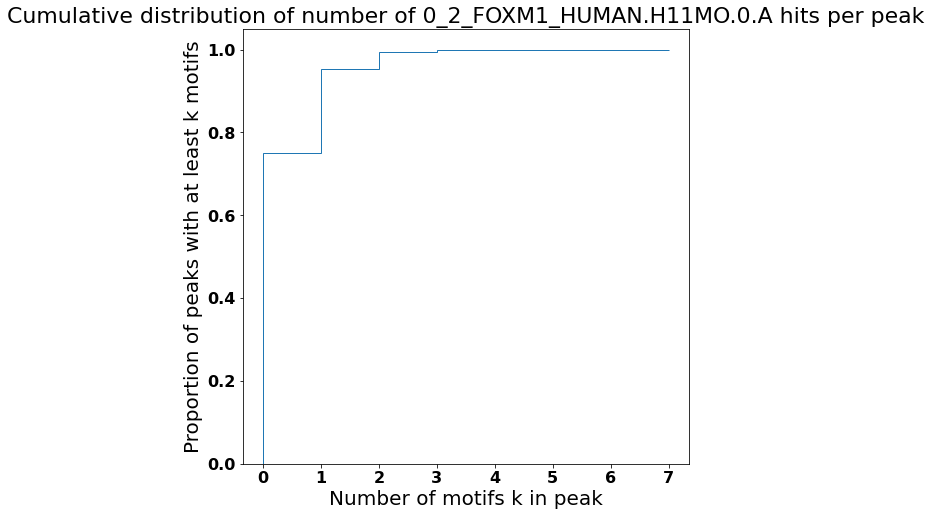

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


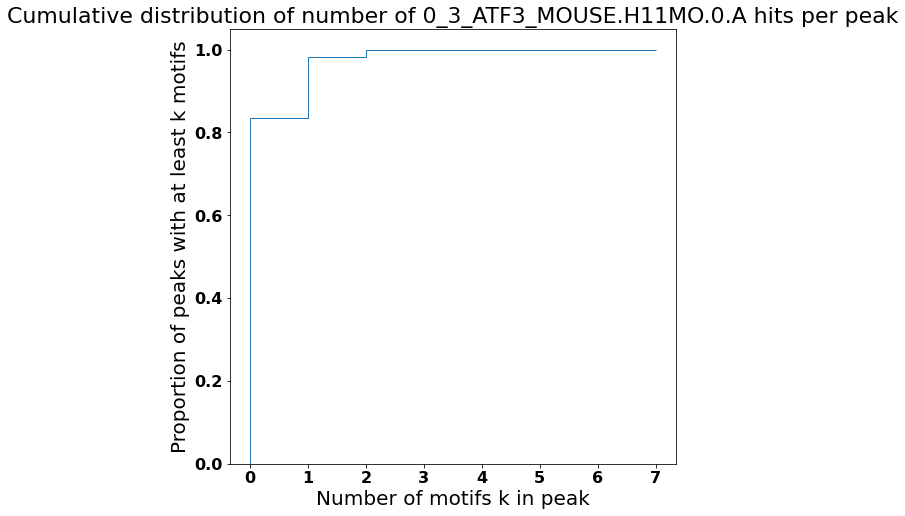

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


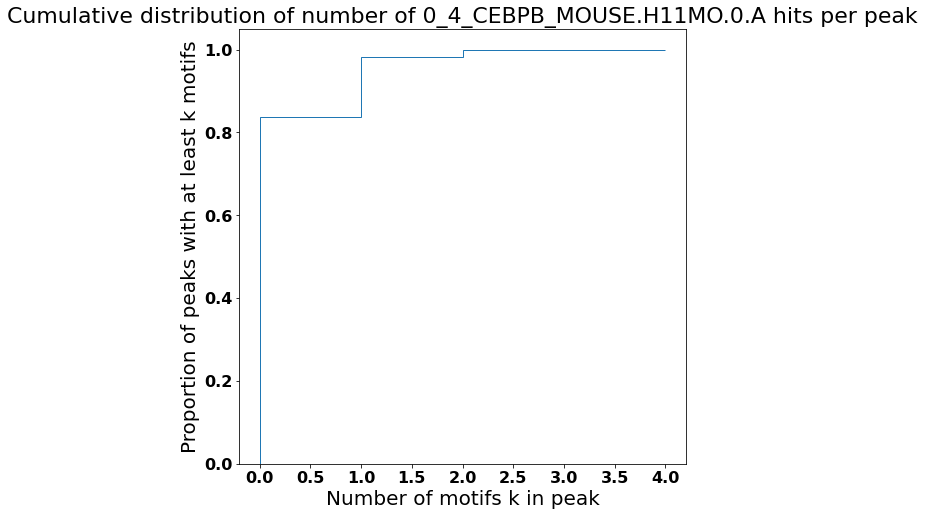

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


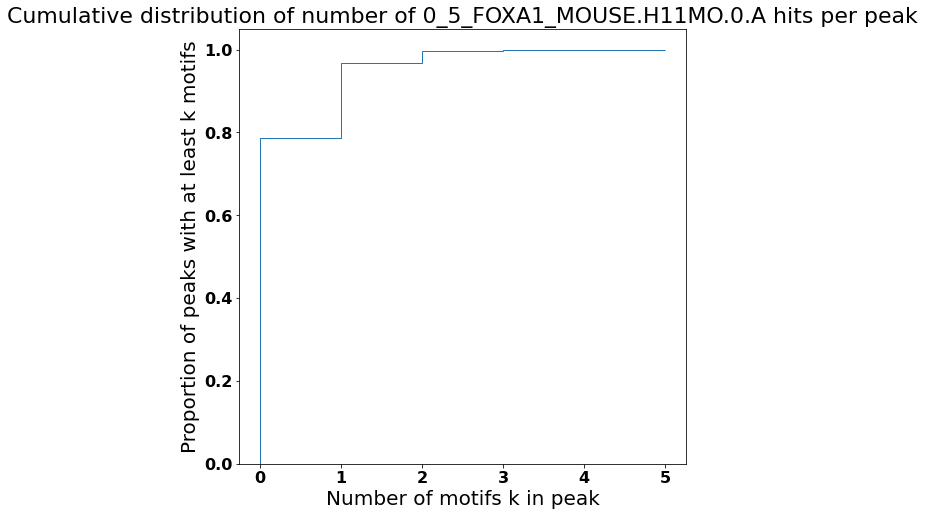

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


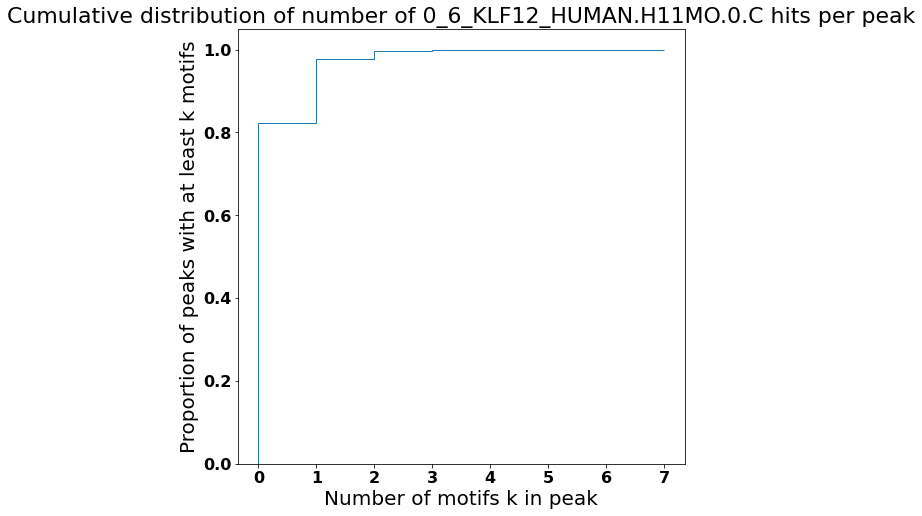

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


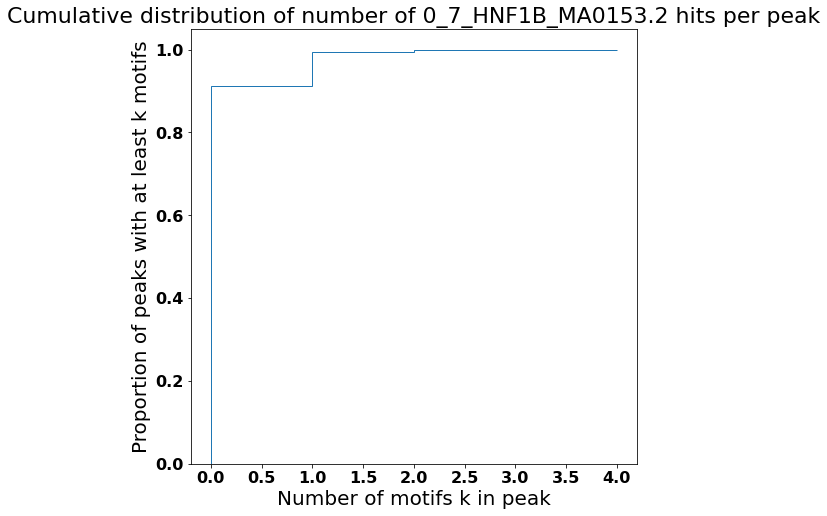

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


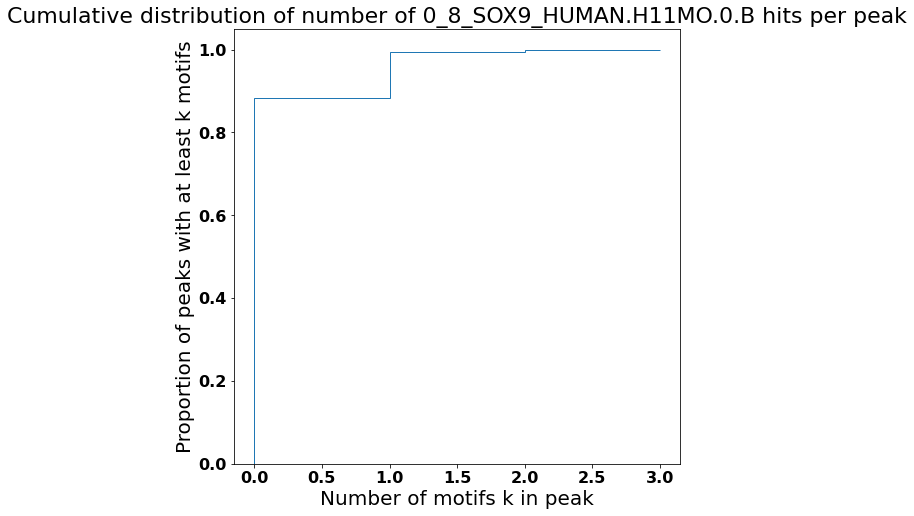

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


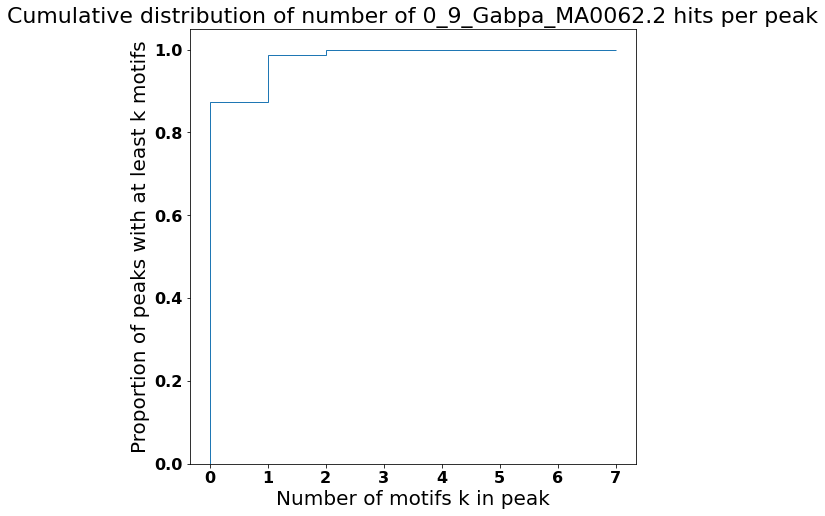

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


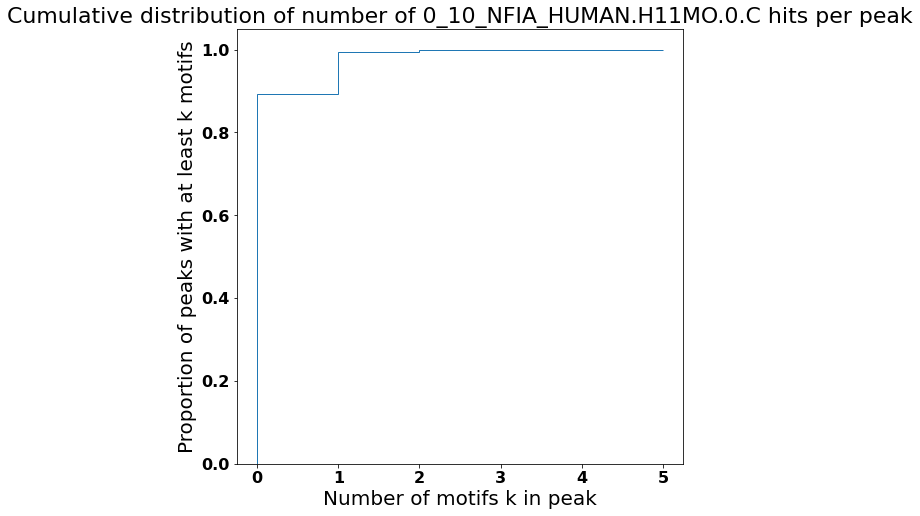

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


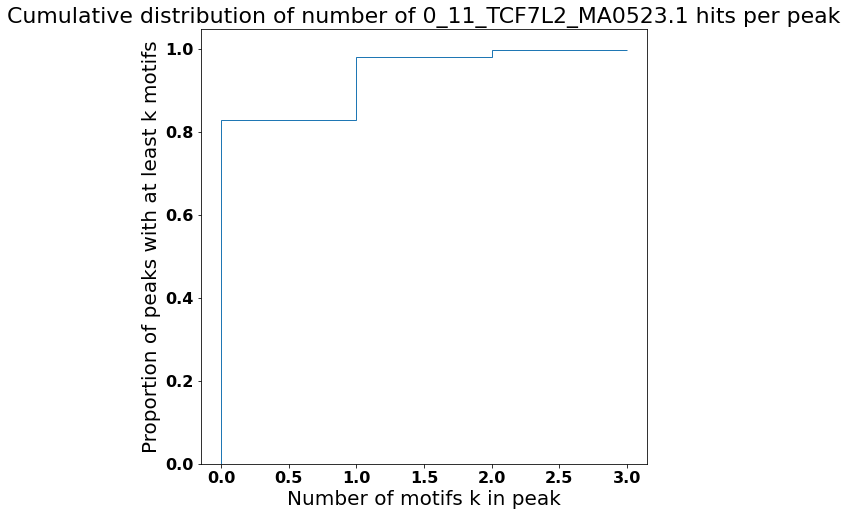

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


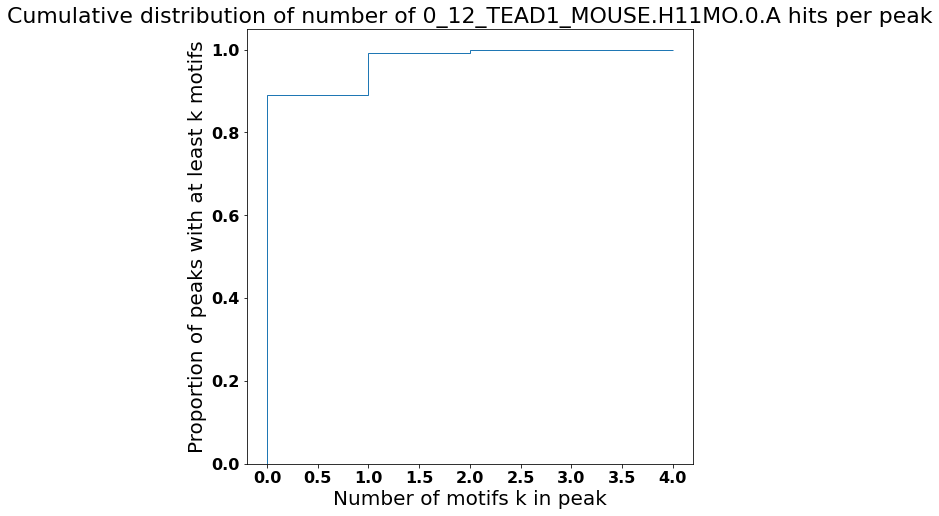

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


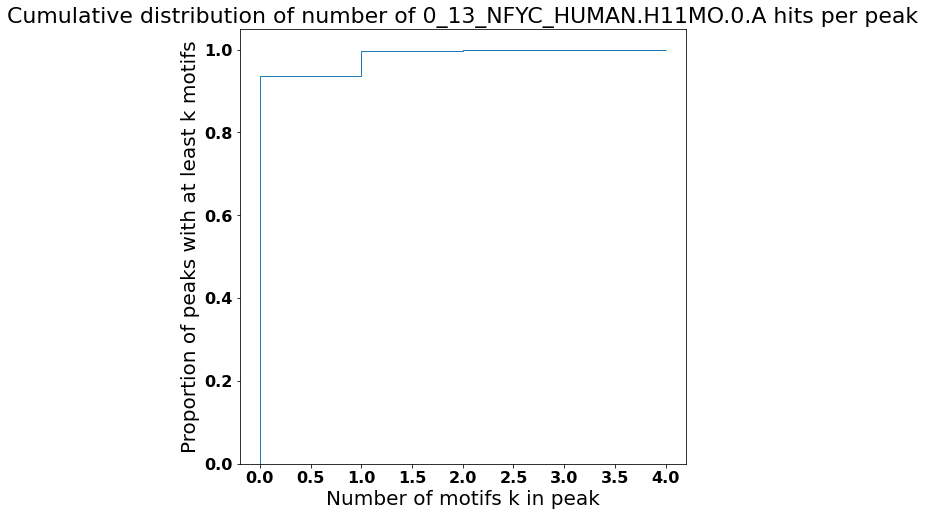

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


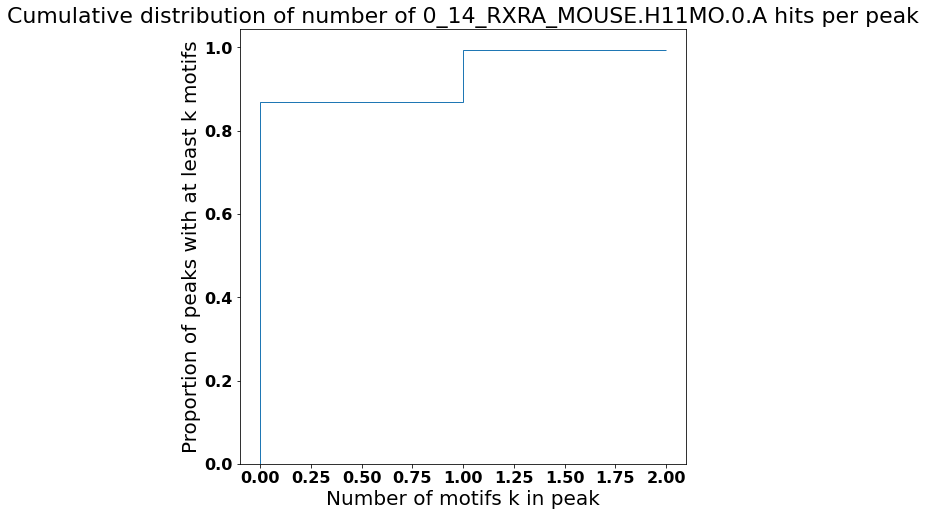

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


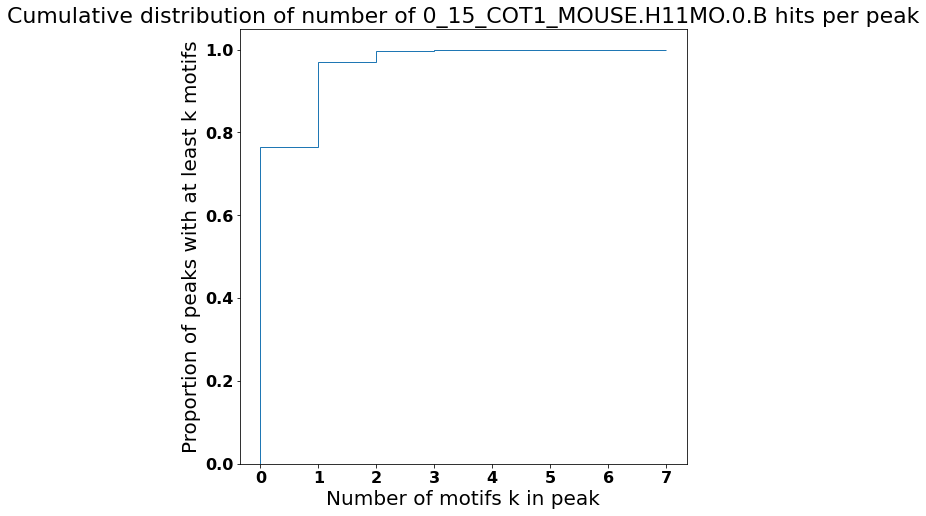

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


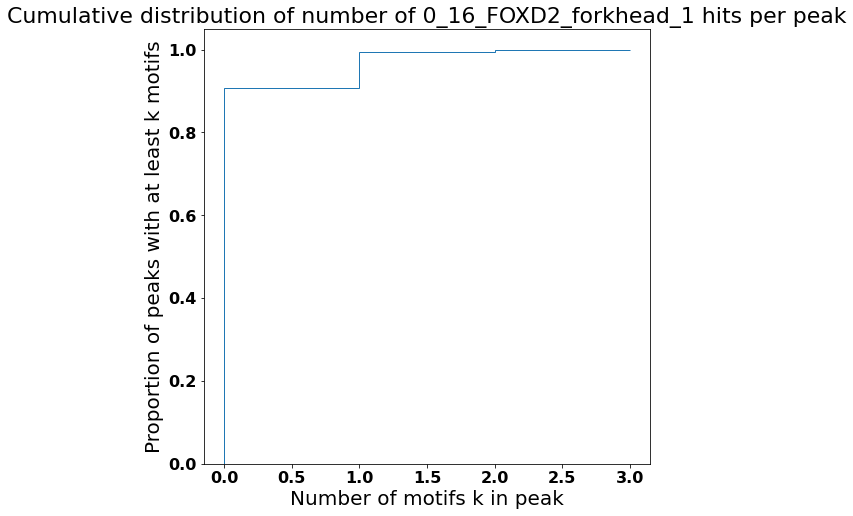

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


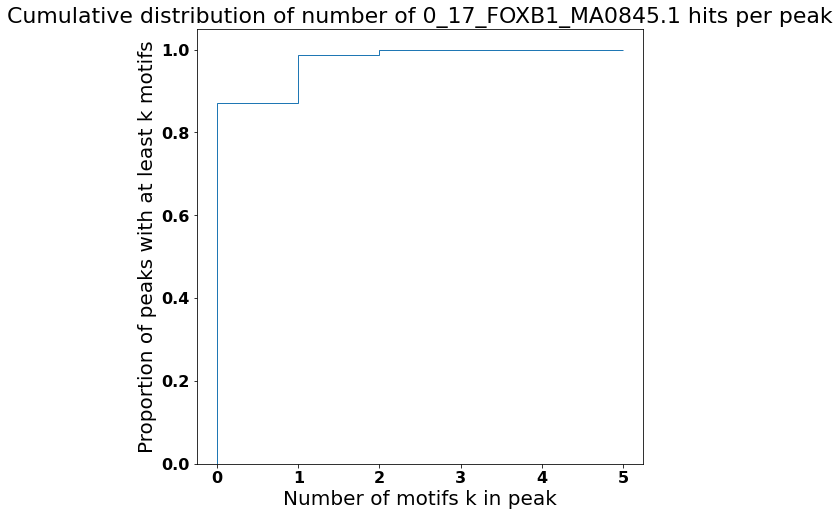

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


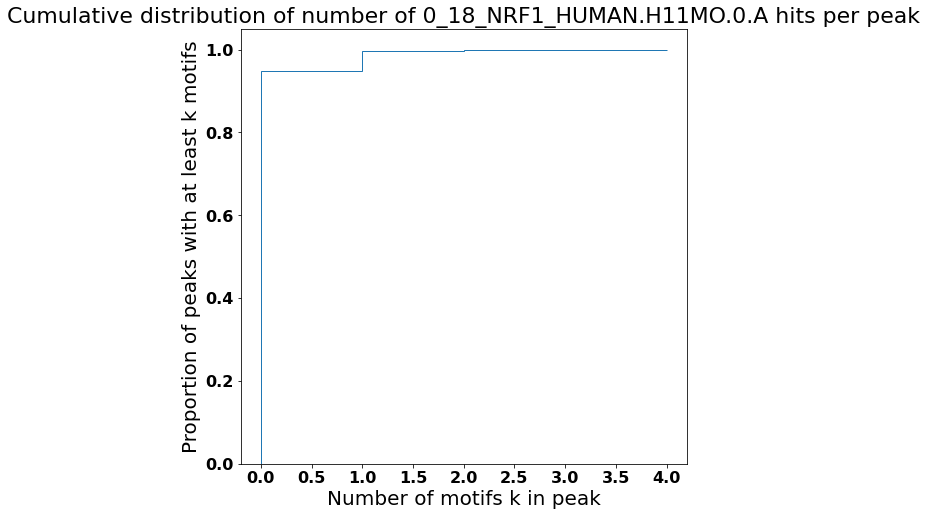

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


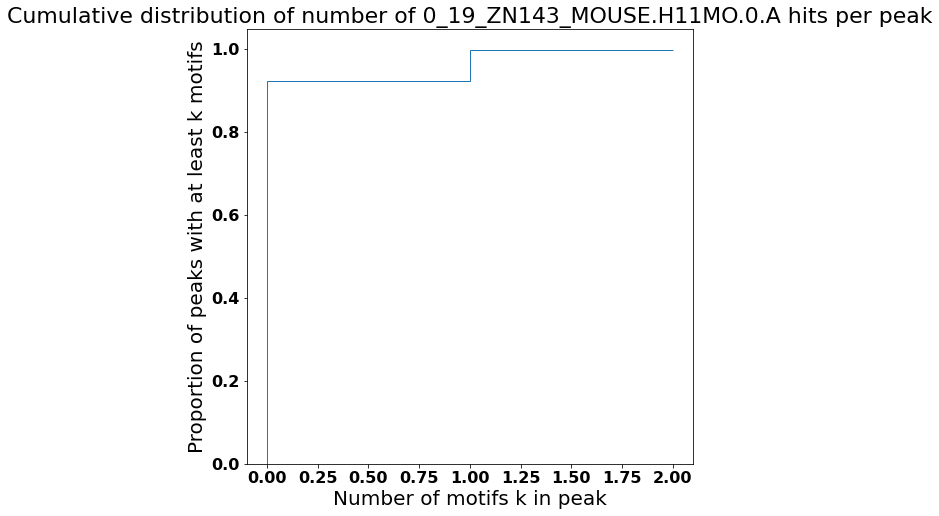

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


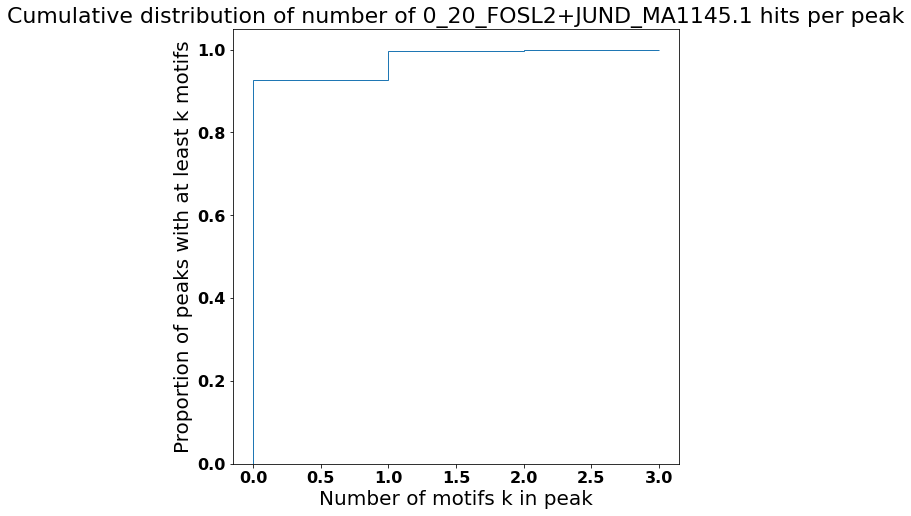

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


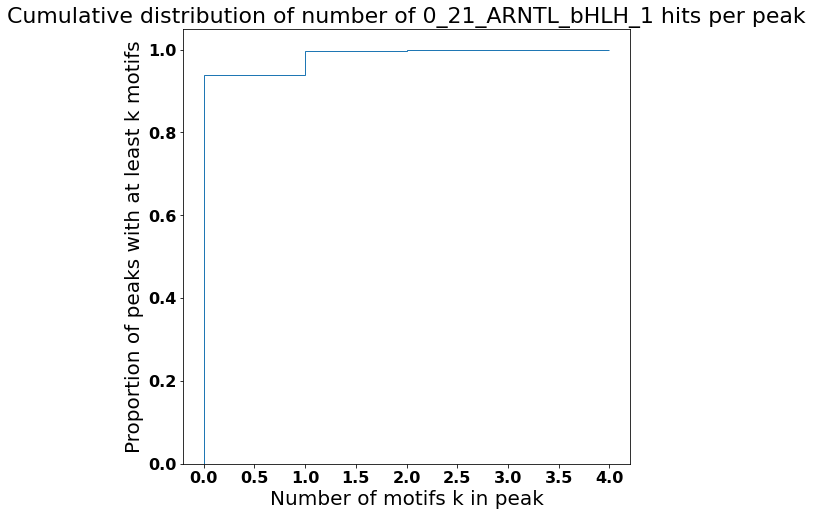

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


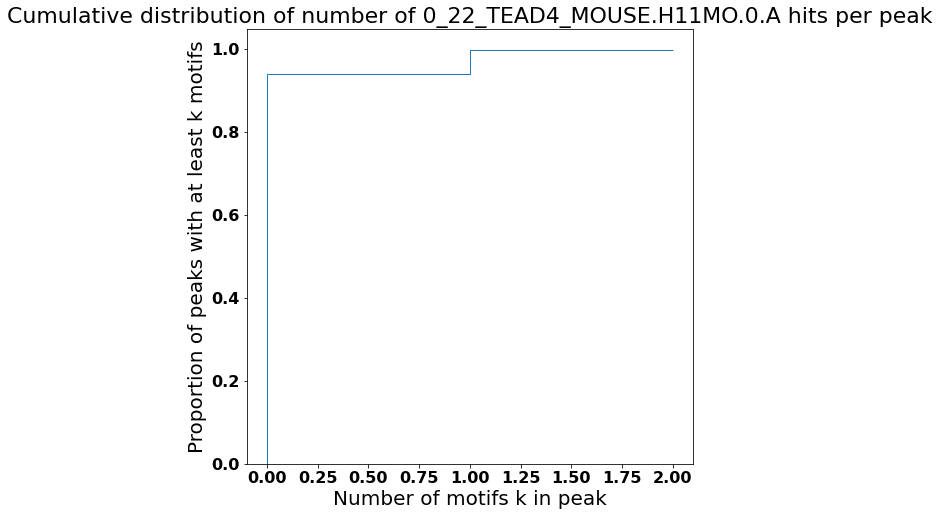

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


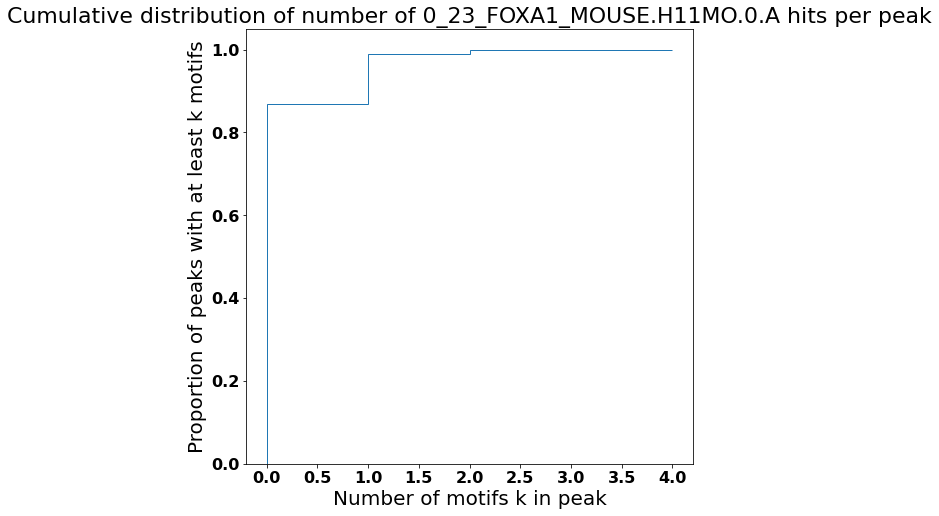

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


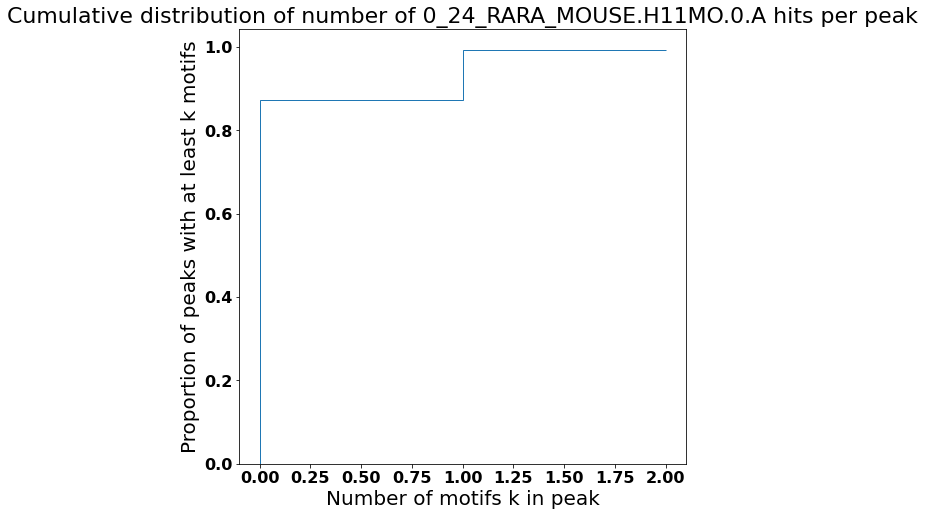

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


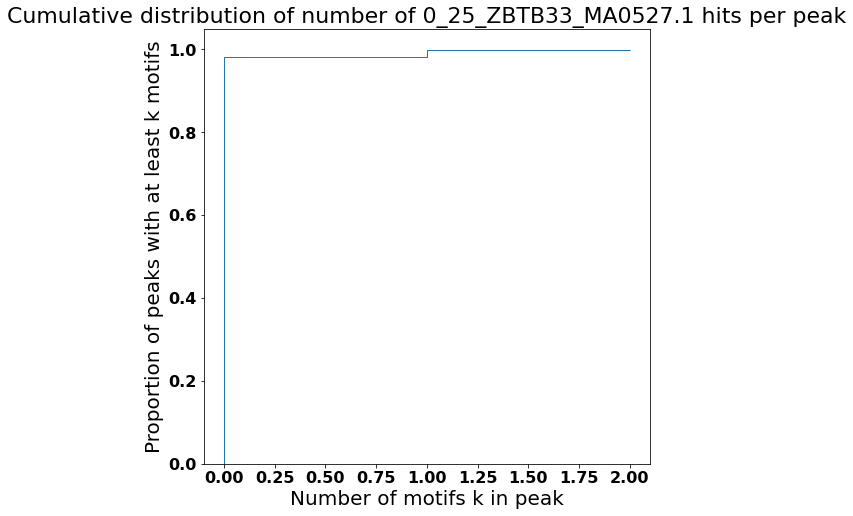

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


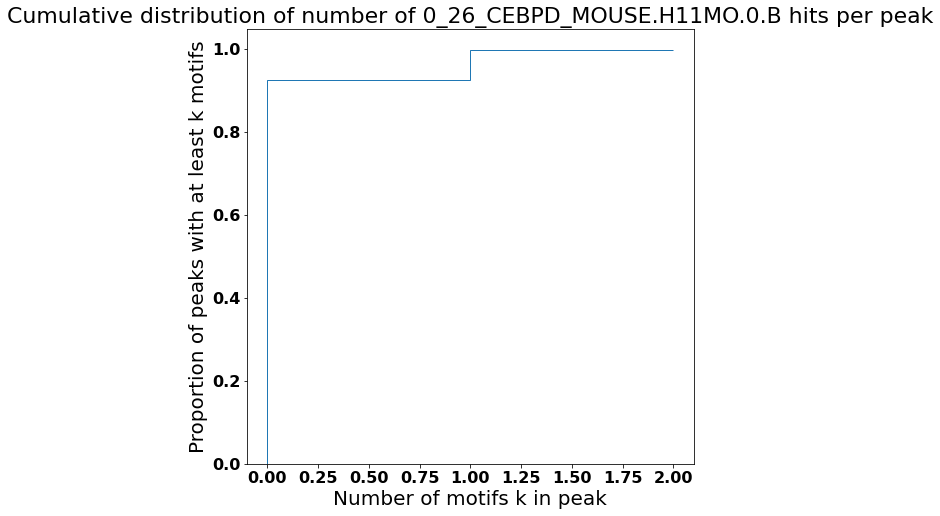

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


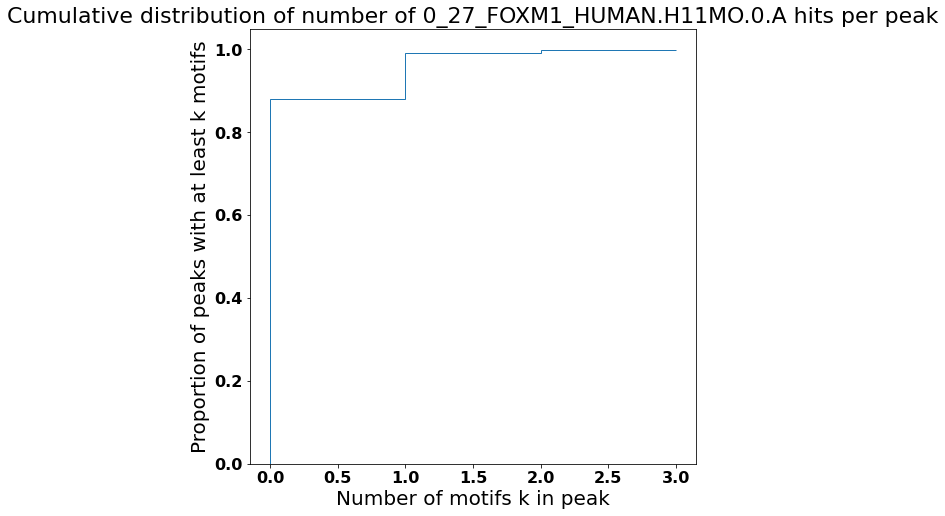

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


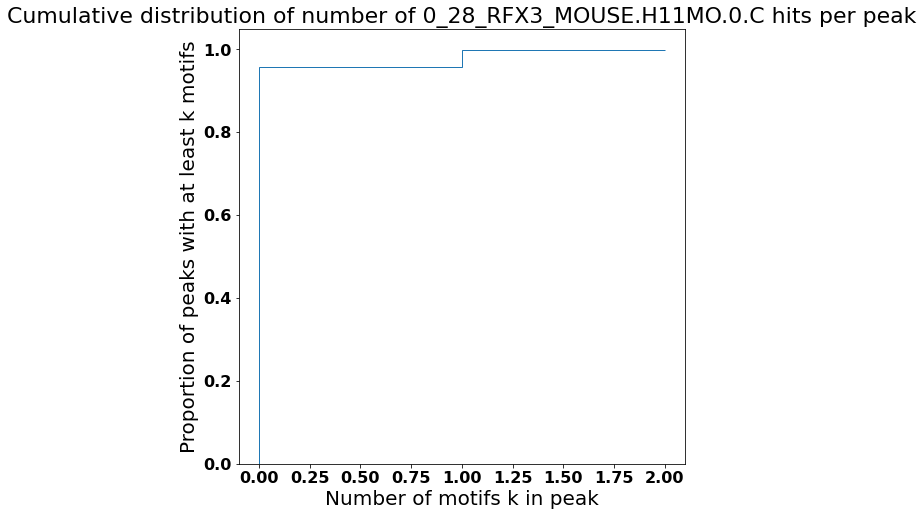

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


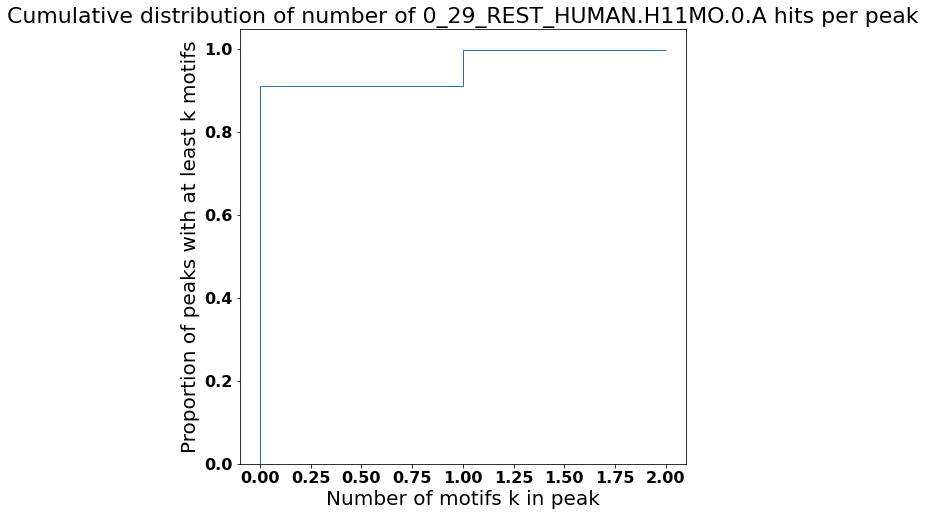

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


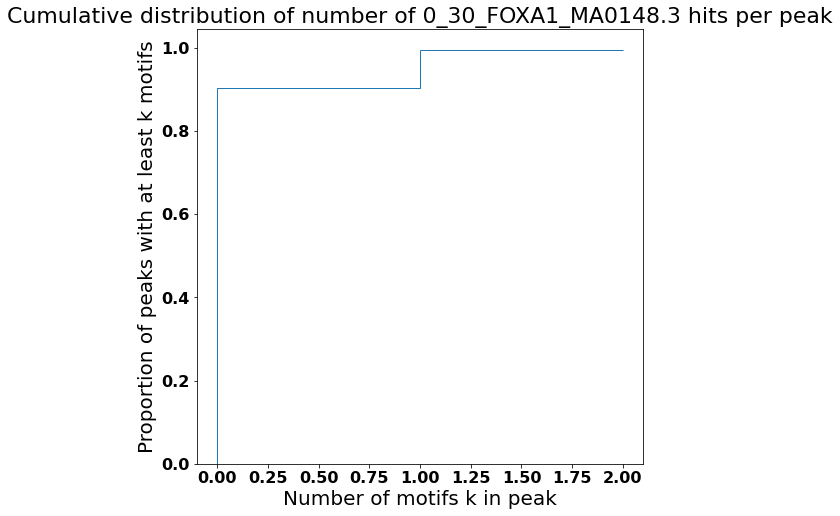

/users/anusri/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6653: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


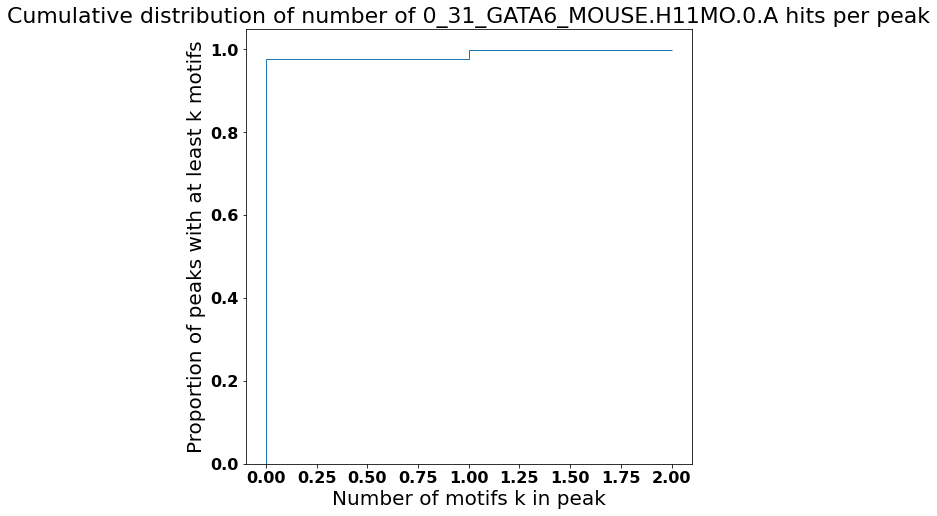

In [52]:
plot_homotypic_densities(peak_hit_counts, motif_keys)

<a id="co-occurrence"></a>
### Co-occurrence of motifs
Proportion of time that motifs co-occur with each other in peaks

In [54]:
#plot_peak_motif_indicator_heatmap(peak_hit_counts, motif_keys)
motif_keys

['0_0_CTCF_MA0139.1',
 '0_1_HNF4G_MA0484.1',
 '0_2_FOXM1_HUMAN.H11MO.0.A',
 '0_3_ATF3_MOUSE.H11MO.0.A',
 '0_4_CEBPB_MOUSE.H11MO.0.A',
 '0_5_FOXA1_MOUSE.H11MO.0.A',
 '0_6_KLF12_HUMAN.H11MO.0.C',
 '0_7_HNF1B_MA0153.2',
 '0_8_SOX9_HUMAN.H11MO.0.B',
 '0_9_Gabpa_MA0062.2',
 '0_10_NFIA_HUMAN.H11MO.0.C',
 '0_11_TCF7L2_MA0523.1',
 '0_12_TEAD1_MOUSE.H11MO.0.A',
 '0_13_NFYC_HUMAN.H11MO.0.A',
 '0_14_RXRA_MOUSE.H11MO.0.A',
 '0_15_COT1_MOUSE.H11MO.0.B',
 '0_16_FOXD2_forkhead_1',
 '0_17_FOXB1_MA0845.1',
 '0_18_NRF1_HUMAN.H11MO.0.A',
 '0_19_ZN143_MOUSE.H11MO.0.A',
 '0_20_FOSL2+JUND_MA1145.1',
 '0_21_ARNTL_bHLH_1',
 '0_22_TEAD4_MOUSE.H11MO.0.A',
 '0_23_FOXA1_MOUSE.H11MO.0.A',
 '0_24_RARA_MOUSE.H11MO.0.A',
 '0_25_ZBTB33_MA0527.1',
 '0_26_CEBPD_MOUSE.H11MO.0.B',
 '0_27_FOXM1_HUMAN.H11MO.0.A',
 '0_28_RFX3_MOUSE.H11MO.0.C',
 '0_29_REST_HUMAN.H11MO.0.A',
 '0_30_FOXA1_MA0148.3',
 '0_31_GATA6_MOUSE.H11MO.0.A']

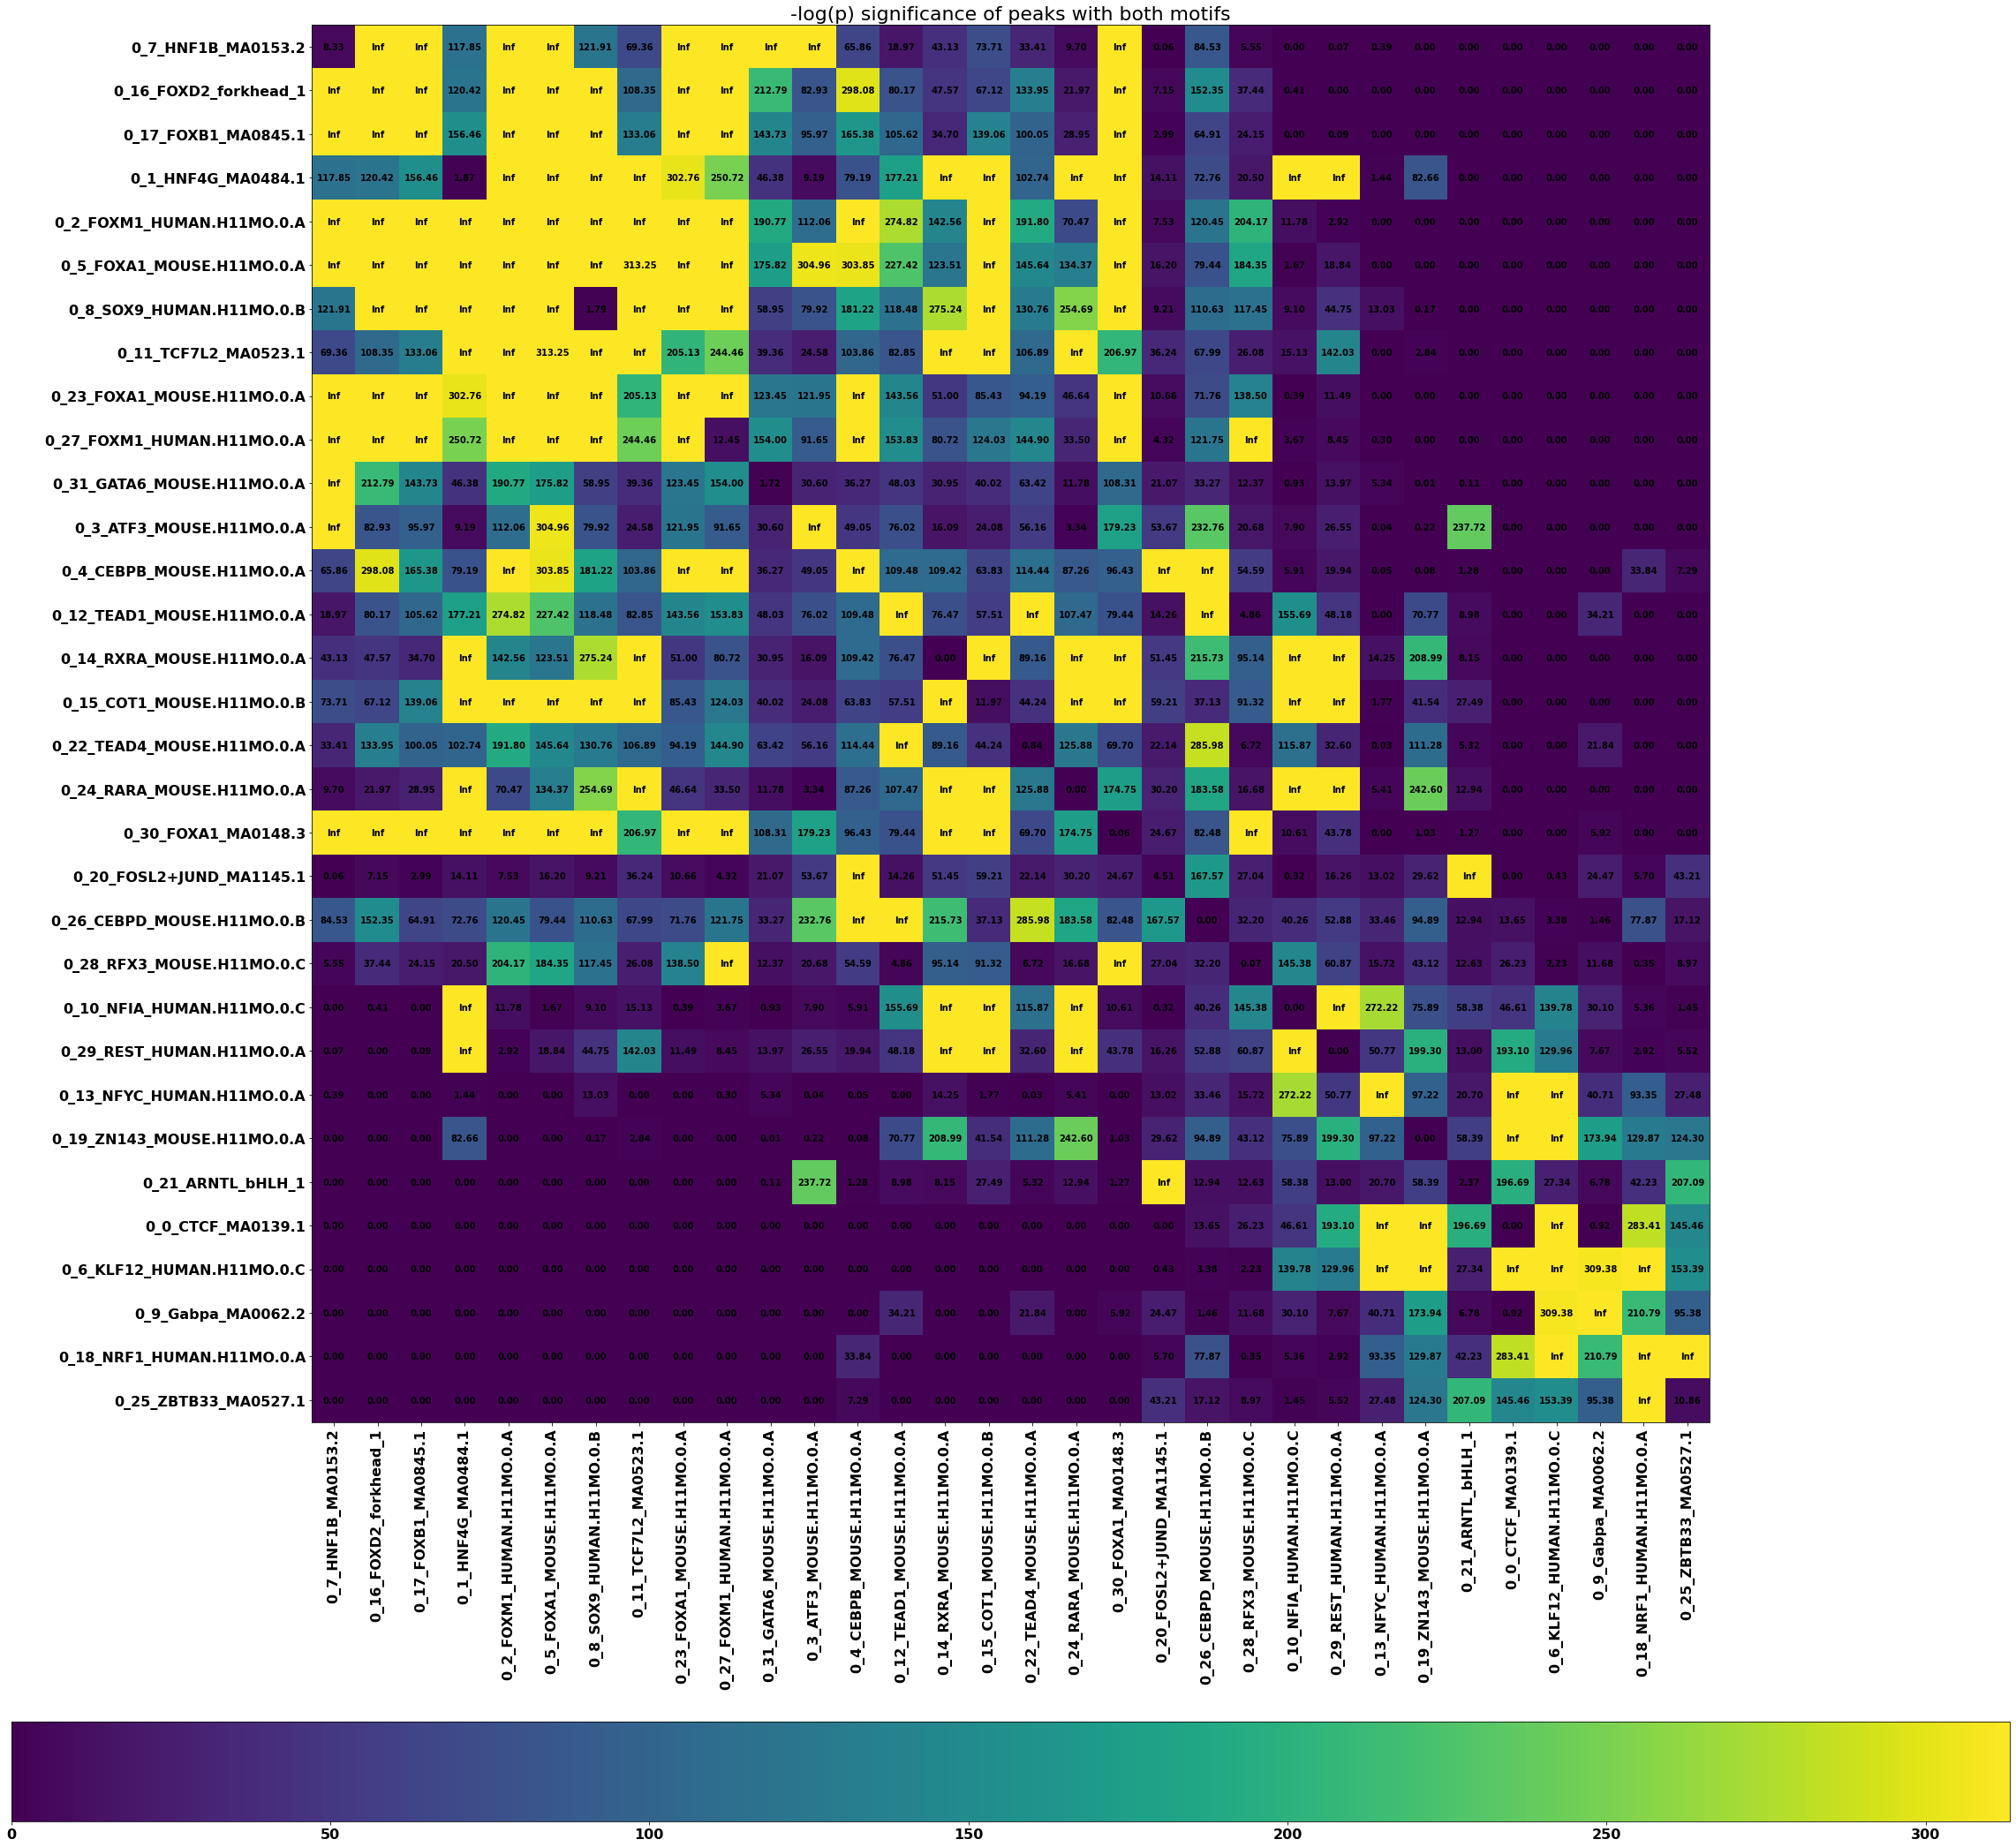

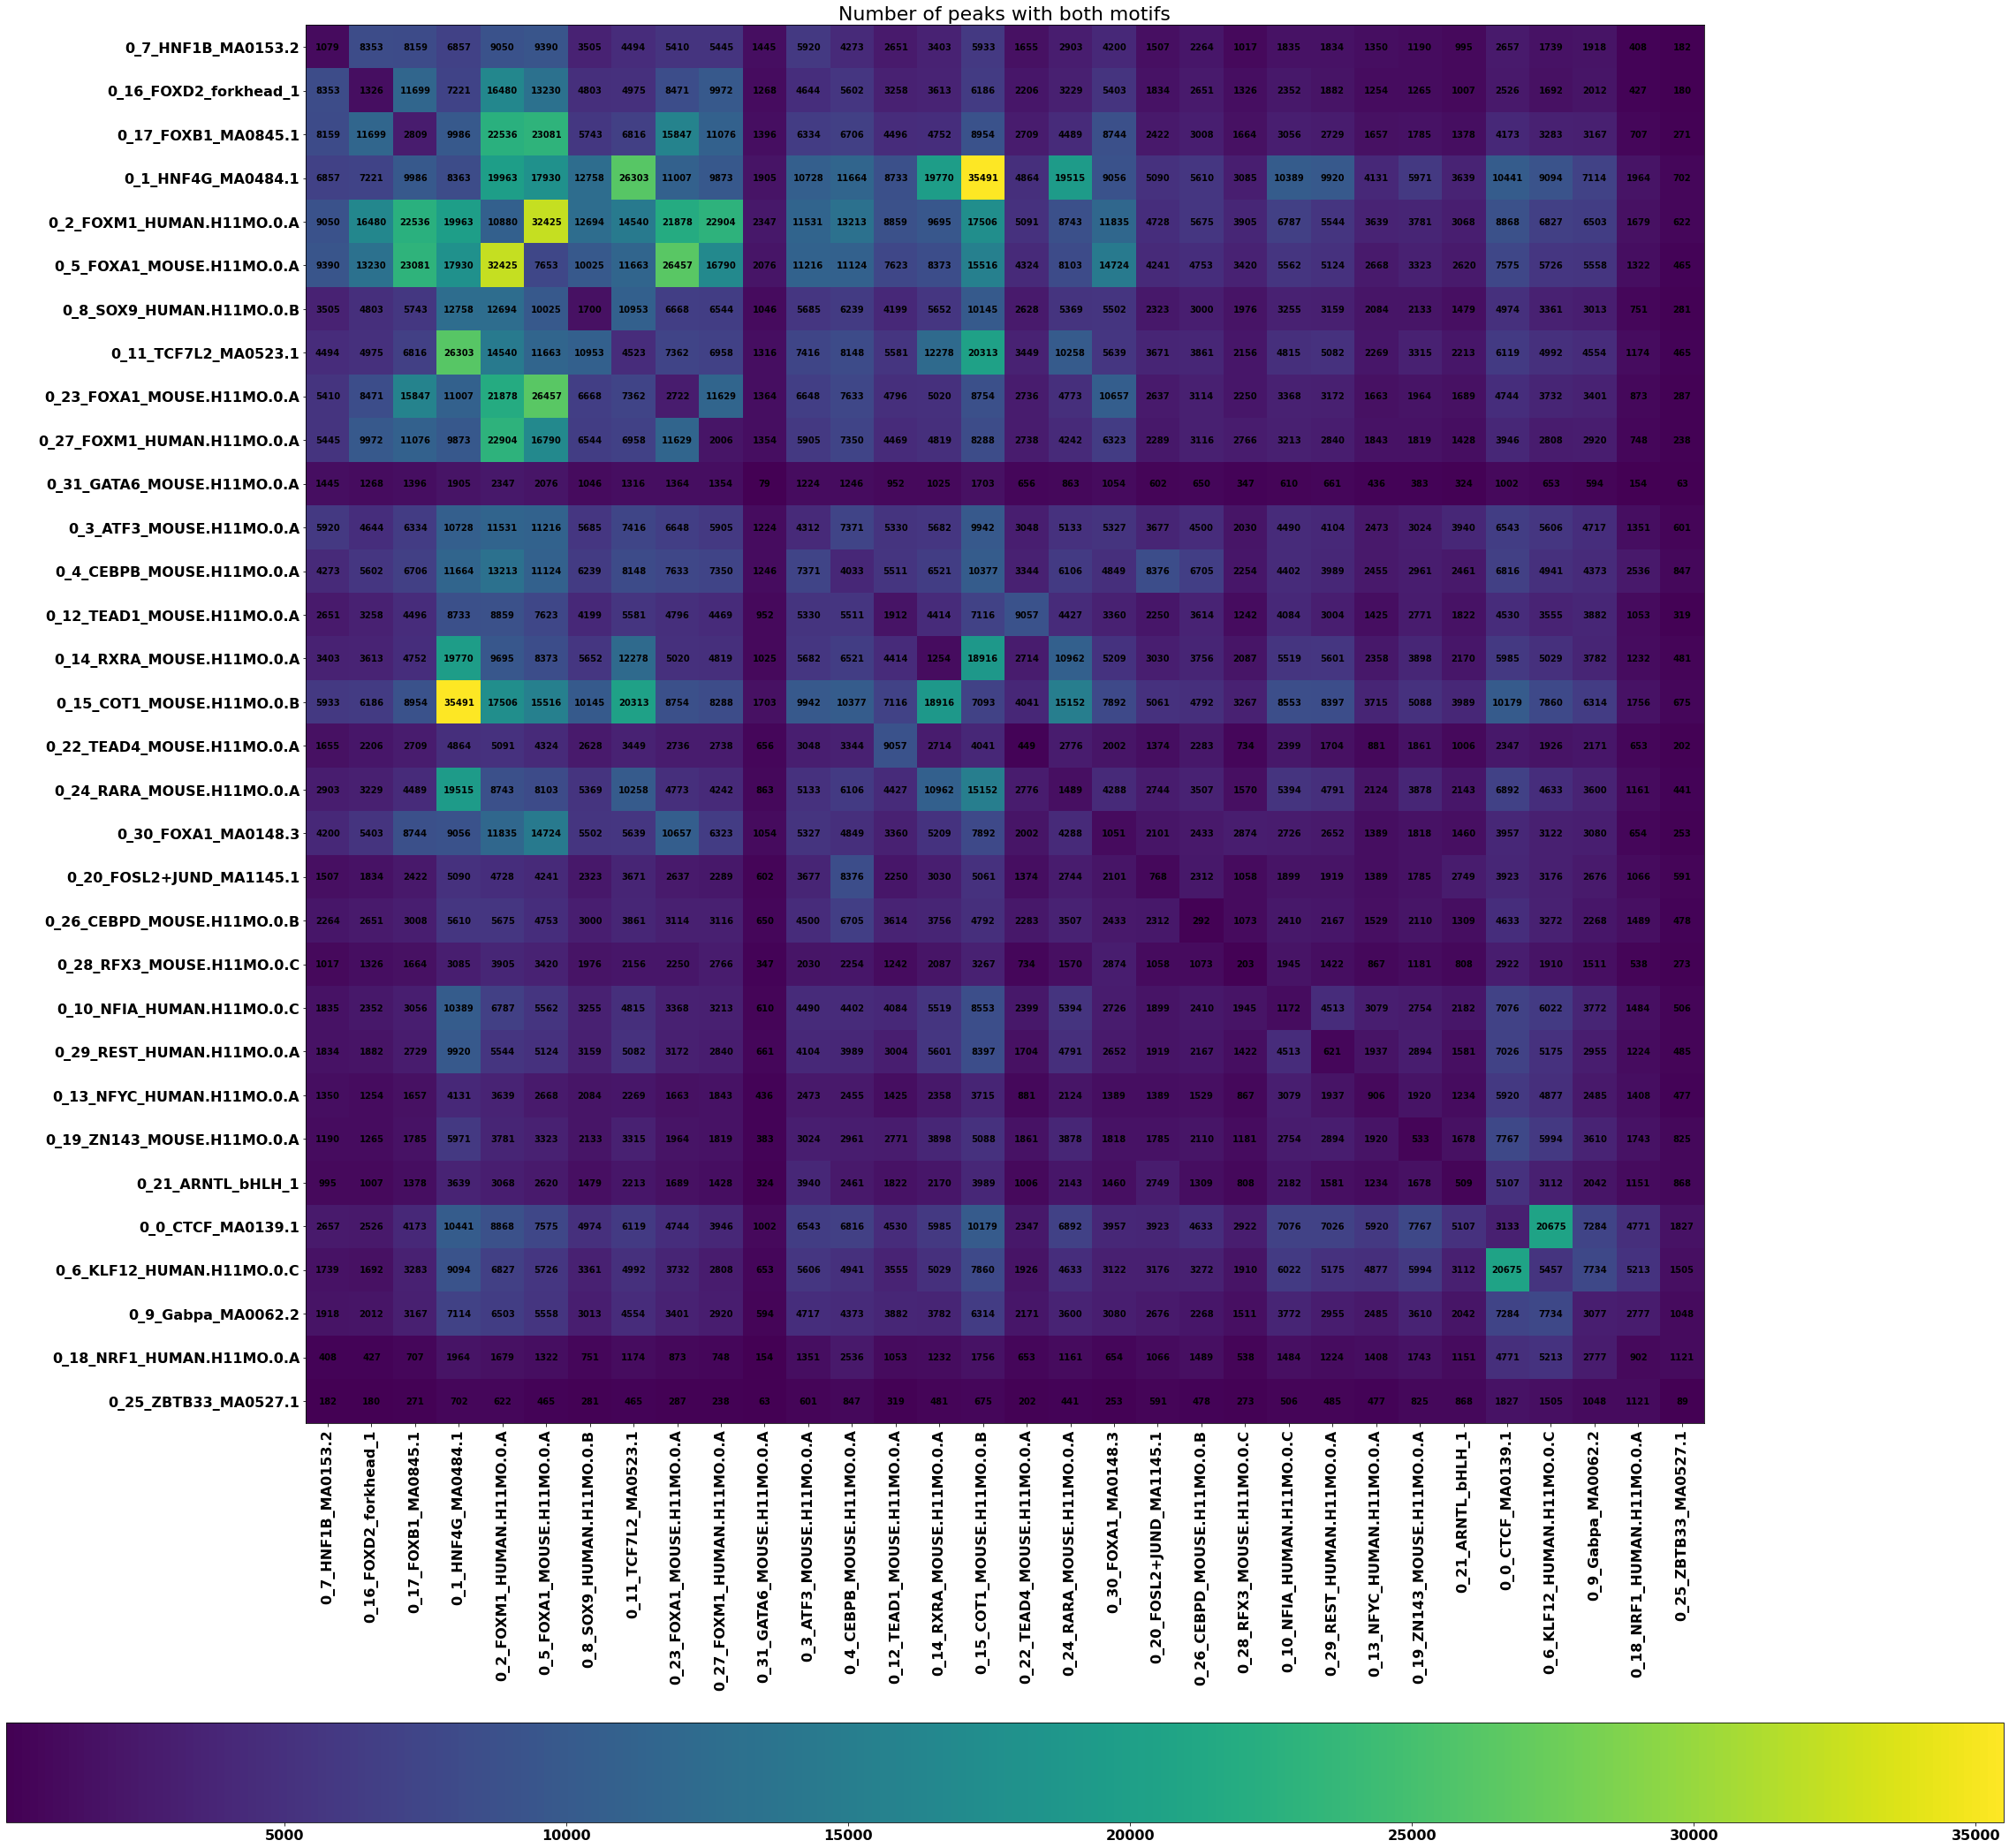

In [55]:
plot_motif_cooccurrence_heatmaps(motif_cooccurrence_count_matrix, motif_cooccurrence_pval_matrix, motif_keys)

<a id="distance"></a>
### Distribution of distances between motifs
When motifs co-occur, show the distance between the instances

In [ ]:
# # Get which pairs of motifs are significant
pvals, sig_pairs = [], []
for i in range(len(motif_keys)):
     for j in range(i + 1):
        if motif_cooccurrence_pval_matrix[i, j] < 1e-6:
            sig_pairs.append((i, j))
            pvals.append(motif_cooccurrence_pval_matrix[i, j])
inds = np.argsort(pvals)
sig_pairs = [sig_pairs[i] for i in inds]

In [ ]:
#plot_intermotif_distance_violins(peak_hits, motif_keys, sig_pairs)